In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from scipy import stats
from adjustText import adjust_text

In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
adata = sc.read('annotated.h5ad')
adata.obs

samples condition location  n_genes  n_genes_by_counts  \
711_AAACCCAAGTCGGGAT-1     711     Tumor    Right      707                707   
711_AAACCCACAGAGGAAA-1     711     Tumor    Right      838                838   
711_AAACCCACATGATAGA-1     711     Tumor    Right      435                435   
711_AAACCCAGTCTCGCGA-1     711     Tumor    Right      579                579   
711_AAACGAAGTTATCTTC-1     711     Tumor    Right     1384               1384   
...                        ...       ...      ...      ...                ...   
706_TTTGGTTCAAACACCT-1     706     Tumor     Left     1815               1815   
706_TTTGGTTCAACGGGTA-1     706     Tumor     Left      909                909   
706_TTTGGTTTCTATCGCC-1     706     Tumor     Left     4658               4658   
706_TTTGTTGCATCAGCGC-1     706     Tumor     Left      374                374   
706_TTTGTTGGTTCCTTGC-1     706     Tumor     Left     1875               1875   

                        log1p_n_genes_by_counts  total_counts  \
711_AAACCCAAGTCGGGAT-1                 6.562444        1396.0   
711_AAACCCACAGAGGAAA-1                 6.732211        1504.0   
711_AAACCCACATGATAGA-1                 6.077642         613.0   
711_AAACCCAGTCTCGCGA-1                 6.363028         860.0   
711_AAACGAAGTTATCTTC-1                 7.233455        2629.0   
...                                         ...           ...   
706_TTTGGTTCAAACACCT-1                 7.504392        4944.0   
706_TTTGGTTCAACGGGTA-1                 6.813445        3528.0   
706_TTTGGTTTCTATCGCC-1                 8.446556       23600.0   
706_TTTGTTGCATCAGCGC-1                 5.926926         686.0   
706_TTTGTTGGTTCCTTGC-1                 7.536897        4189.0   

                        log1p_total_counts  pct_counts_in_top_20_genes  \
711_AAACCCAAGTCGGGAT-1            7.242083                   26.862464   
711_AAACCCACAGAGGAAA-1            7.316548                   23.803191   
711_AAACCCACATGATAGA-1            6.419995                   17.781403   
711_AAACCCAGTCTCGCGA-1            6.758094                   23.255814   
711_AAACGAAGTTATCTTC-1            7.874739                   19.246862   
...                                    ...                         ...   
706_TTTGGTTCAAACACCT-1            8.506132                   21.318770   
706_TTTGGTTCAACGGGTA-1            8.168770                   34.722222   
706_TTTGGTTTCTATCGCC-1           10.069044                   17.559322   
706_TTTGTTGCATCAGCGC-1            6.532334                   23.032070   
706_TTTGTTGGTTCCTTGC-1            8.340456                   22.177131   

                        pct_counts_mt  pct_counts_ribo  pct_counts_hb  \
711_AAACCCAAGTCGGGAT-1      10.100286        25.716331       0.000000   
711_AAACCCACAGAGGAAA-1       9.441490        13.962767       0.000000   
711_AAACCCACATGATAGA-1       0.815661        18.270800       0.000000   
711_AAACCCAGTCTCGCGA-1      15.465117         6.395349       0.000000   
711_AAACGAAGTTATCTTC-1       8.178015        15.405098       0.000000   
...                               ...              ...            ...   
706_TTTGGTTCAAACACCT-1       1.961974        21.318771       0.020227   
706_TTTGGTTCAACGGGTA-1       0.368481        25.368483       0.000000   
706_TTTGGTTTCTATCGCC-1       3.237288        18.135593       0.004237   
706_TTTGTTGCATCAGCGC-1      10.932944        33.236153       0.000000   
706_TTTGTTGGTTCCTTGC-1       6.182860        12.628312       0.000000   

                                        low_label  low_score  _scvi_batch  \
711_AAACCCAAGTCGGGAT-1  T follicular helper cells   0.103311            0   
711_AAACCCACAGAGGAAA-1                    Unknown   0.236022            0   
711_AAACCCACATGATAGA-1                    Unknown   0.400460            0   
711_AAACCCAGTCTCGCGA-1               Tip-like ECs   0.966648            0   
711_AAACGAAGTTATCTTC-1        gamma delta T cells   0.993837            0   
...                                      

In [5]:
    
    print("\nCell type distribution:")
    print(adata.obs['Cell_Type'].value_counts())
    
    print("\nSample distribution:")
    print(adata.obs['location'].value_counts())  # 'left' or 'right'
    
    print("\nTumor vs Normal distribution:")
    print(adata.obs['condition'].value_counts())  # 'tumor' or 'normal'


Cell type distribution:
Cell_Type
CD4+ T Cells                    17357
B Cells                         10774
CD8+ T cells                     6676
Regulatory T Cells               3907
CMS3                             3876
Helper 17 T cells                2377
Dendritic cells                  2105
CMS2                             1792
Spp1+                            1634
Follicular helper T cells        1486
Gamma delta T cells              1336
NK cells                         1320
Stromal 2                         897
Mast cells                        642
Tip-like ECs                      610
Pericytes                         457
Mature Enterocytes type 2         326
Plasma Cells                      240
Plasmacytoid Dendritic Cells       89
Stromal 3                          65
Enteric glia cells                 49
Name: count, dtype: int64

Sample distribution:
location
Left     32344
Right    25671
Name: count, dtype: int64

Tumor vs Normal distribution:
condition
Tumor     436

In [7]:

#  scanpy rank method : Use the full adata (not adata_tumor) since we need both tumor and normal
cell_types = adata.obs['Cell_Type'].unique()
deg_results = {}

print(f"Found {len(cell_types)} cell types")
print(f"Starting Tumor vs Normal DEG analysis...\n")

for cell_type in cell_types:
    print(f"{'='*60}")
    print(f"Analyzing {cell_type}...")
    print(f"{'='*60}")
    
    # Subset to only this cell type
    adata_subset = adata[adata.obs['Cell_Type'] == cell_type].copy()
    
    # Check if both conditions exist
    conditions = adata_subset.obs['condition'].unique()
    print(f"  Conditions present: {conditions}")
    
    if len(conditions) < 2:
        print(f"  ⚠️ Skipping - only one condition present\n")
        continue
    
    # Check sample sizes
    n_tumor = (adata_subset.obs['condition'] == 'Tumor').sum()
    n_normal = (adata_subset.obs['condition'] == 'Normal').sum()
    print(f"  Tumor cells: {n_tumor}")
    print(f"  Normal cells: {n_normal}")
    
    if n_tumor < 10 or n_normal < 10:
        print(f"  ⚠️ Skipping - too few cells in one condition\n")
        continue
    
    # Run DEG analysis comparing tumor vs normal
    sc.tl.rank_genes_groups(
        adata_subset,
        groupby='condition',      # column with tumor/normal labels
        groups=['Tumor'],         # test tumor vs normal
        reference='Normal',       # compare to normal
        method='wilcoxon',        # Wilcoxon rank-sum test
        key_added=f'deg_{cell_type}'
    )
    
    # Extract results
    deg_df = sc.get.rank_genes_groups_df(
        adata_subset, 
        group='Tumor',
        key=f'deg_{cell_type}'
    )
    
    # Add metadata
    deg_df['Cell_Type'] = cell_type
    deg_df['n_tumor'] = n_tumor
    deg_df['n_normal'] = n_normal
    
    deg_results[cell_type] = deg_df
    
    print(f"  ✅ Tested {len(deg_df)} genes\n")

# Combine all results
if deg_results:
    all_degs = pd.concat(deg_results.values(), ignore_index=True)
    
    print(f"{'='*60}")
    print(f"COMBINED RESULTS")
    print(f"{'='*60}")
    print(f"Total genes tested: {len(all_degs)}")
    print(f"Cell types analyzed: {len(deg_results)}")
    
    # Filter by criteria
    significant_degs = all_degs[
        (all_degs['pvals_adj'] < 0.05) & 
        (abs(all_degs['logfoldchanges']) > 0.5)
    ]
    
    print(f"\nSignificant DEGs (p_adj < 0.05, |log2FC| > 0.5): {len(significant_degs)}")
    
    # Summary per cell type
    print(f"\nDEGs per cell type:")
    summary = significant_degs.groupby('Cell_Type').size().sort_values(ascending=False)
    print(summary)
    
    # Save results
    all_degs.to_csv('tumor_vs_normal_DEGs_all.csv', index=False)
    significant_degs.to_csv('tumor_vs_normal_DEGs_significant.csv', index=False)
    
    print(f"\n✅ Results saved:")
    print(f"   - tumor_vs_normal_DEGs_all.csv")
    print(f"   - tumor_vs_normal_DEGs_significant.csv")
    
else:
    print("❌ No DEG results generated!")

Found 21 cell types
Starting Tumor vs Normal DEG analysis...

Analyzing CD4+ T Cells...
  Conditions present: ['Tumor', 'Normal']
Categories (2, object): ['Normal', 'Tumor']
  Tumor cells: 11933
  Normal cells: 5424
  ✅ Tested 14469 genes

Analyzing CMS3...
  Conditions present: ['Tumor', 'Normal']
Categories (2, object): ['Normal', 'Tumor']
  Tumor cells: 2898
  Normal cells: 978
  ✅ Tested 14469 genes

Analyzing Tip-like ECs...
  Conditions present: ['Tumor', 'Normal']
Categories (2, object): ['Normal', 'Tumor']
  Tumor cells: 581
  Normal cells: 29
  ✅ Tested 14469 genes

Analyzing CD8+ T cells...
  Conditions present: ['Tumor', 'Normal']
Categories (2, object): ['Normal', 'Tumor']
  Tumor cells: 5055
  Normal cells: 1621
  ✅ Tested 14469 genes

Analyzing B Cells...
  Conditions present: ['Tumor', 'Normal']
Categories (2, object): ['Normal', 'Tumor']
  Tumor cells: 7021
  Normal cells: 3753
  ✅ Tested 14469 genes

Analyzing Spp1+...
  Conditions present: ['Tumor', 'Normal']
Categori

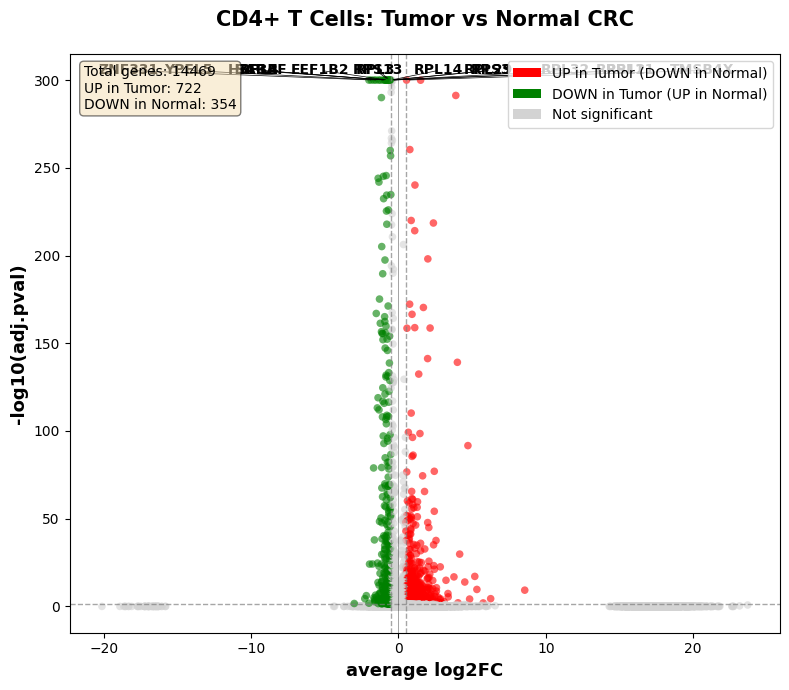


CD4+ T Cells:
  UP in Tumor (DOWN in Normal): 722
  DOWN in Tumor (UP in Normal): 354


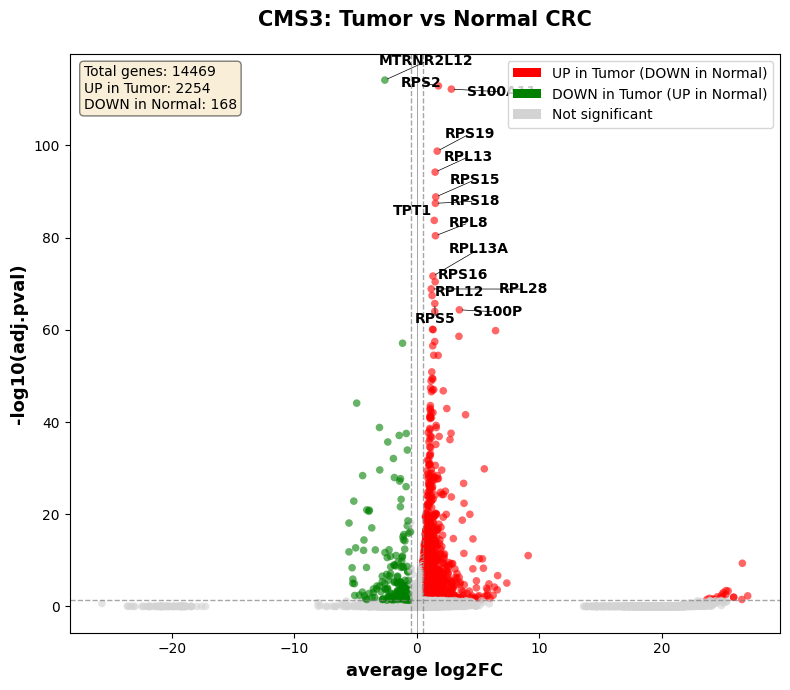


CMS3:
  UP in Tumor (DOWN in Normal): 2254
  DOWN in Tumor (UP in Normal): 168


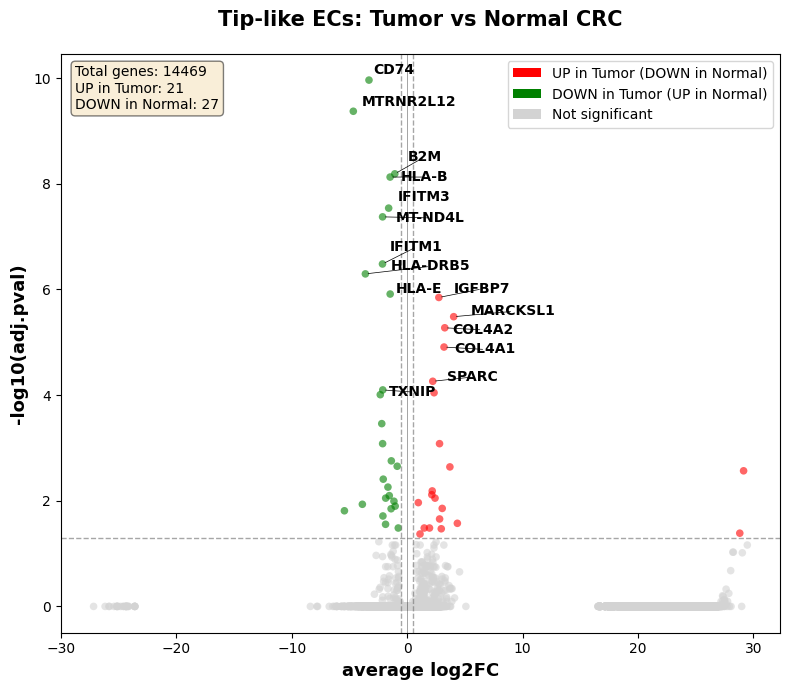


Tip-like ECs:
  UP in Tumor (DOWN in Normal): 21
  DOWN in Tumor (UP in Normal): 27


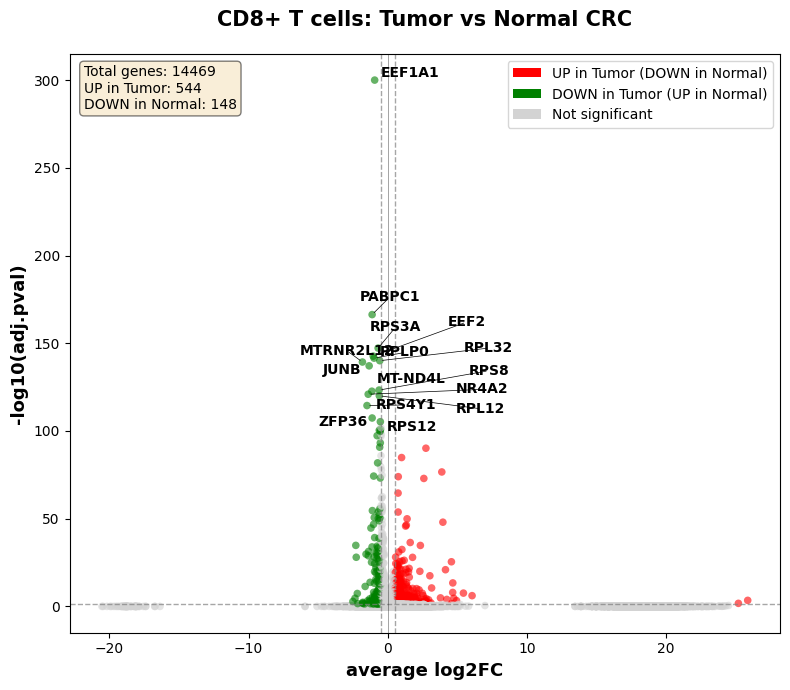


CD8+ T cells:
  UP in Tumor (DOWN in Normal): 544
  DOWN in Tumor (UP in Normal): 148


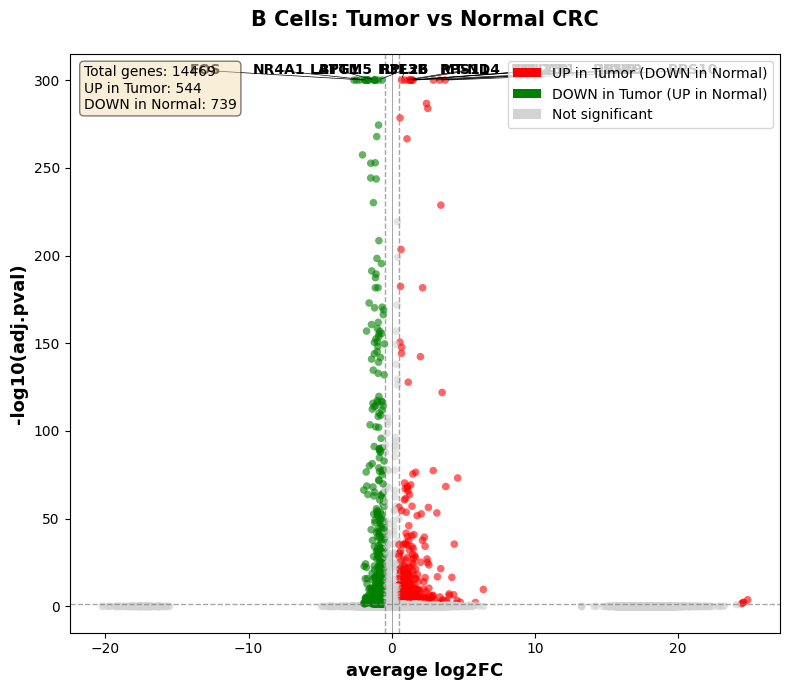


B Cells:
  UP in Tumor (DOWN in Normal): 544
  DOWN in Tumor (UP in Normal): 739


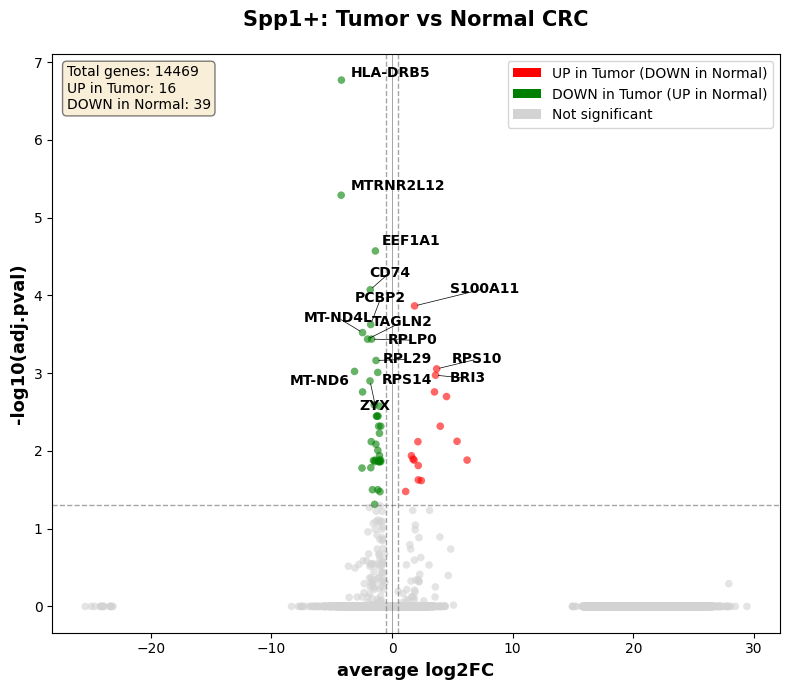


Spp1+:
  UP in Tumor (DOWN in Normal): 16
  DOWN in Tumor (UP in Normal): 39


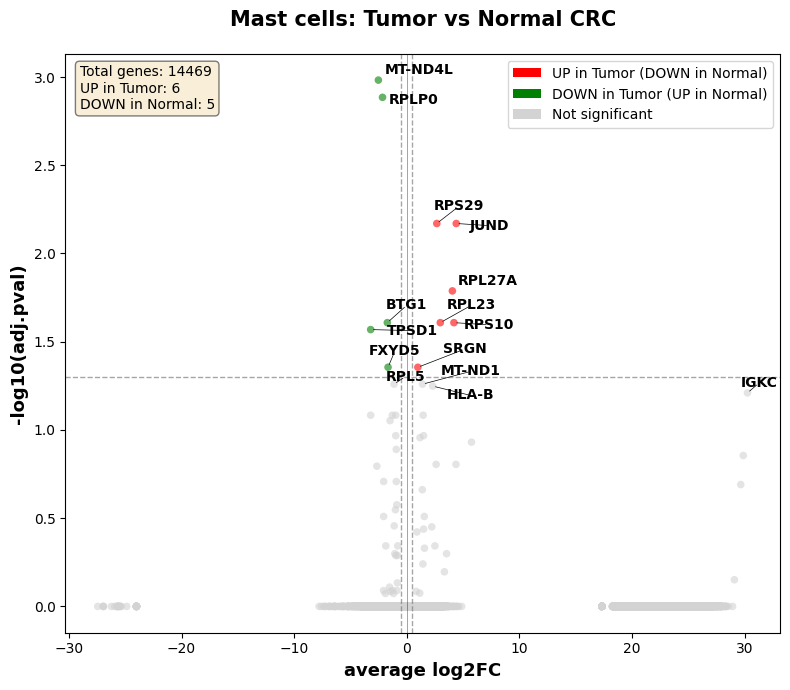


Mast cells:
  UP in Tumor (DOWN in Normal): 6
  DOWN in Tumor (UP in Normal): 5


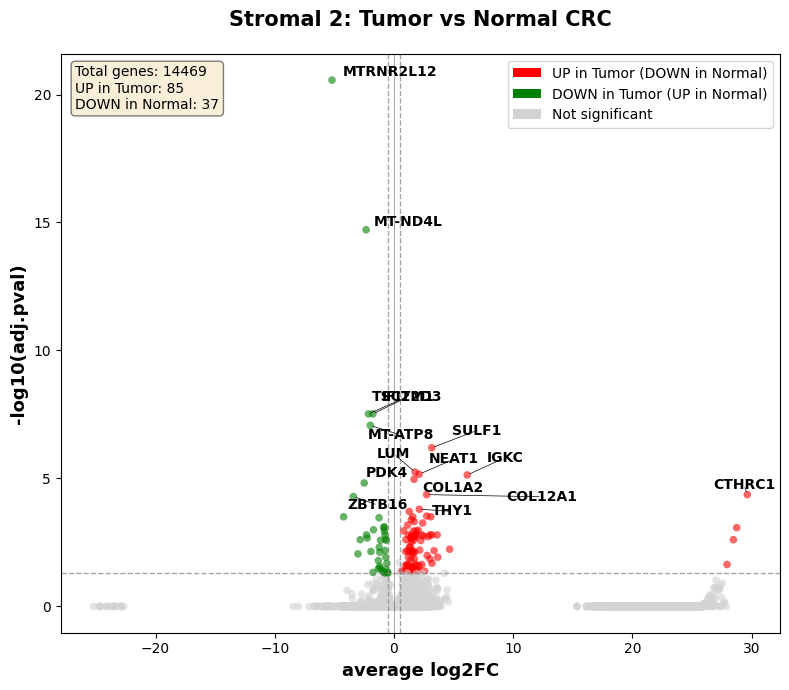


Stromal 2:
  UP in Tumor (DOWN in Normal): 85
  DOWN in Tumor (UP in Normal): 37


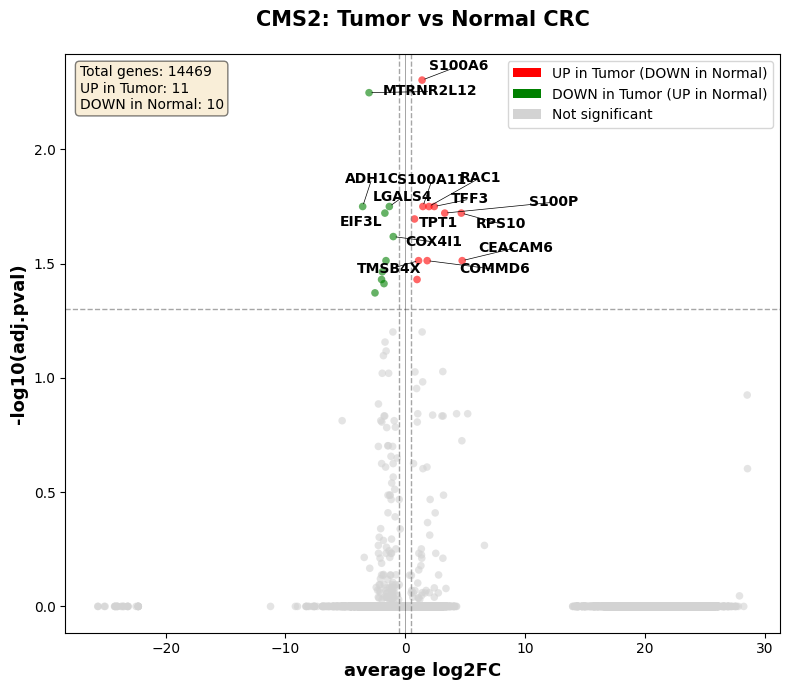


CMS2:
  UP in Tumor (DOWN in Normal): 11
  DOWN in Tumor (UP in Normal): 10


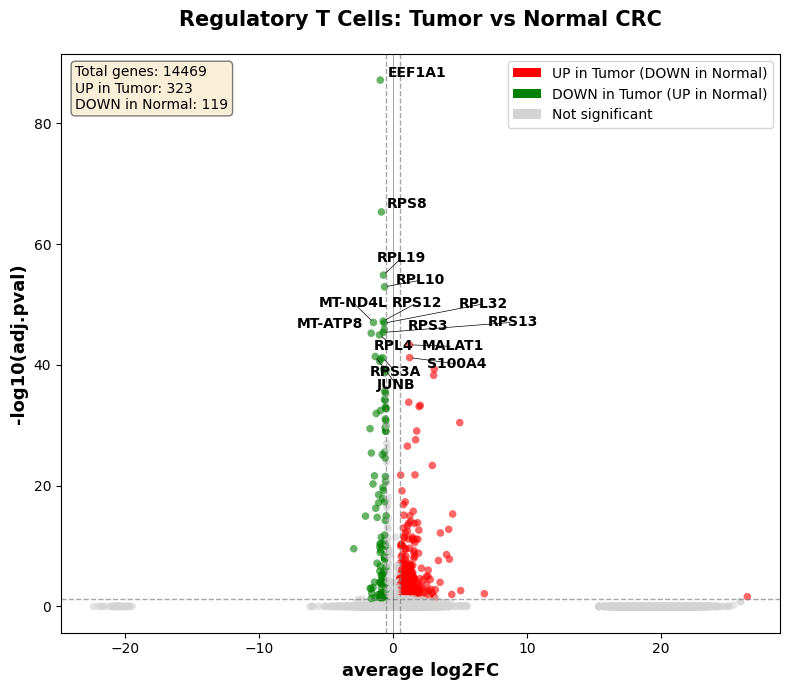


Regulatory T Cells:
  UP in Tumor (DOWN in Normal): 323
  DOWN in Tumor (UP in Normal): 119


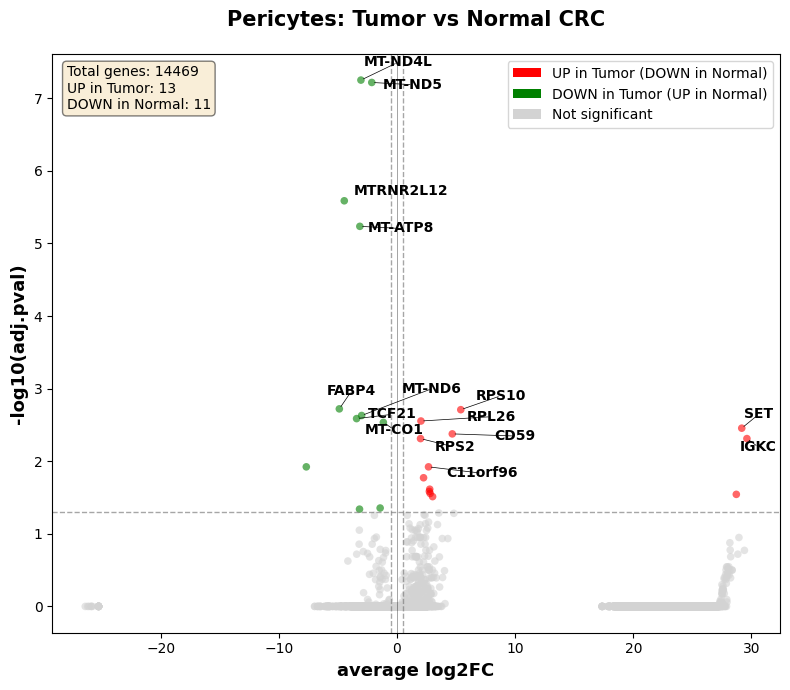


Pericytes:
  UP in Tumor (DOWN in Normal): 13
  DOWN in Tumor (UP in Normal): 11


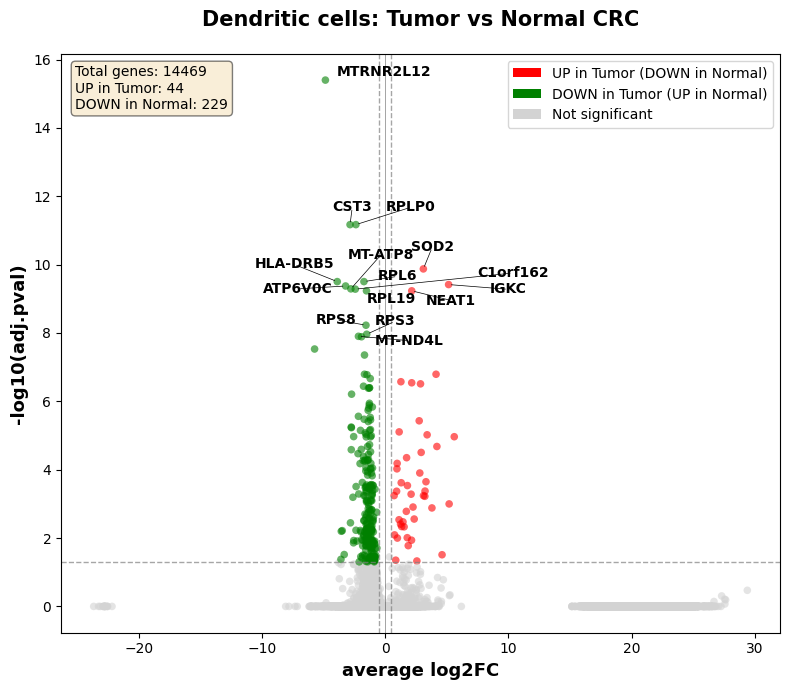


Dendritic cells:
  UP in Tumor (DOWN in Normal): 44
  DOWN in Tumor (UP in Normal): 229


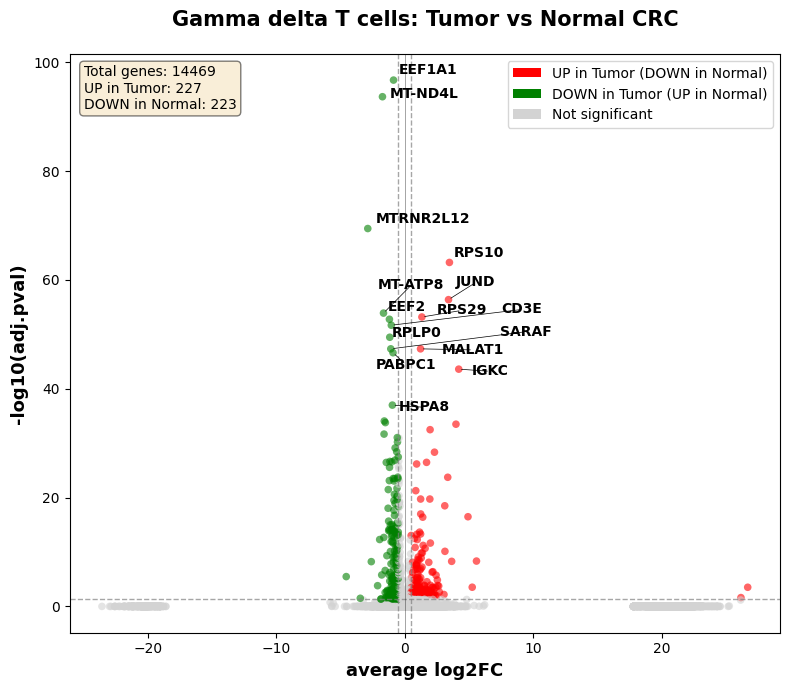


Gamma delta T cells:
  UP in Tumor (DOWN in Normal): 227
  DOWN in Tumor (UP in Normal): 223


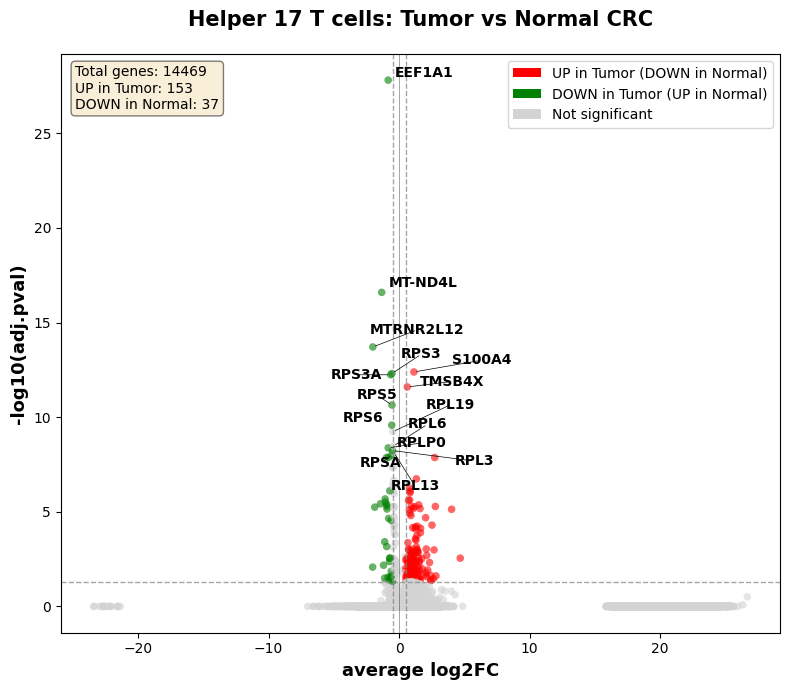


Helper 17 T cells:
  UP in Tumor (DOWN in Normal): 153
  DOWN in Tumor (UP in Normal): 37


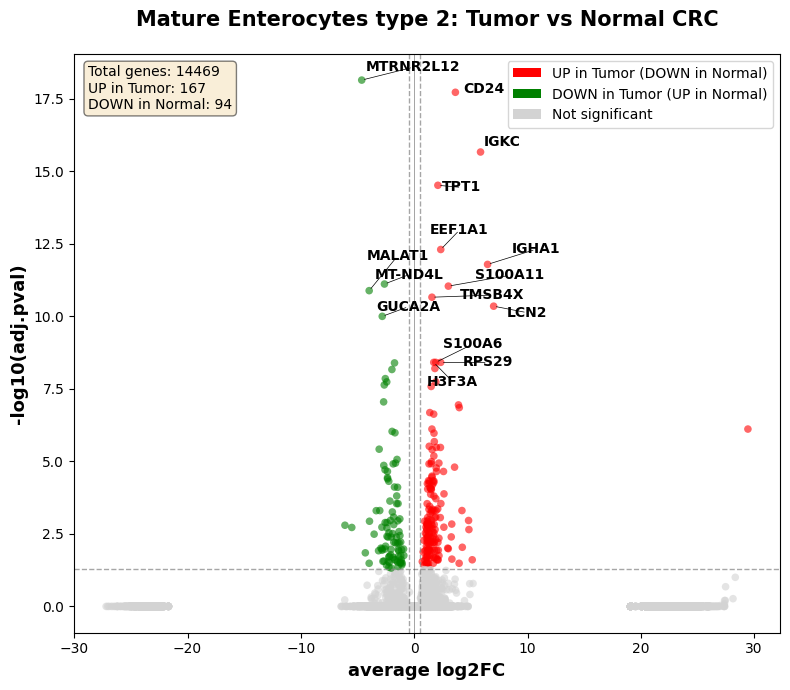


Mature Enterocytes type 2:
  UP in Tumor (DOWN in Normal): 167
  DOWN in Tumor (UP in Normal): 94


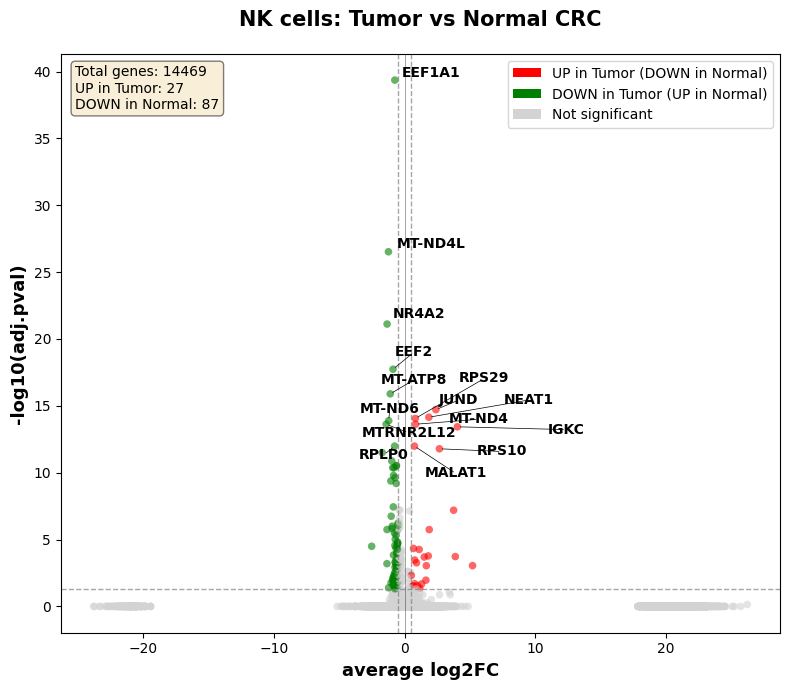


NK cells:
  UP in Tumor (DOWN in Normal): 27
  DOWN in Tumor (UP in Normal): 87


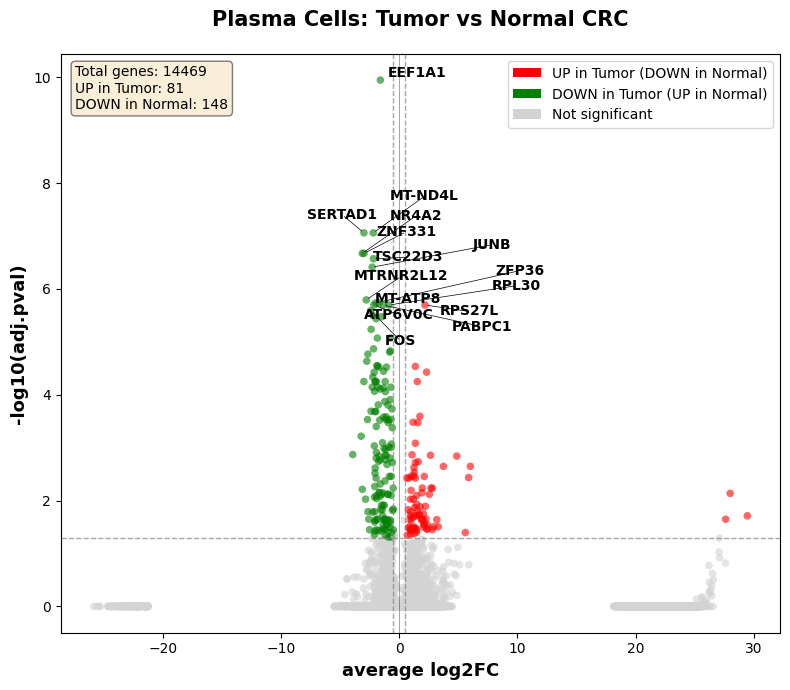


Plasma Cells:
  UP in Tumor (DOWN in Normal): 81
  DOWN in Tumor (UP in Normal): 148


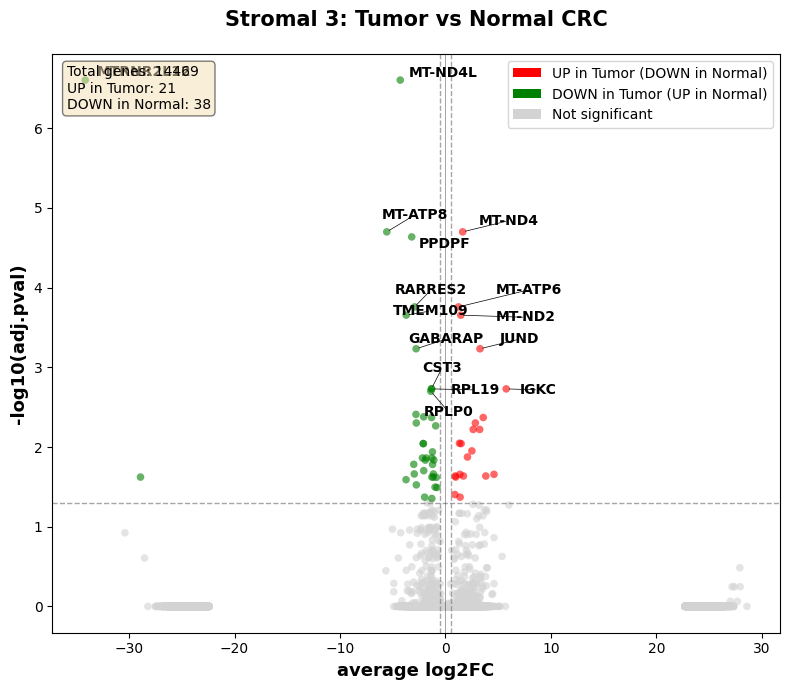


Stromal 3:
  UP in Tumor (DOWN in Normal): 21
  DOWN in Tumor (UP in Normal): 38
No DEGs found for Plasmacytoid Dendritic Cells


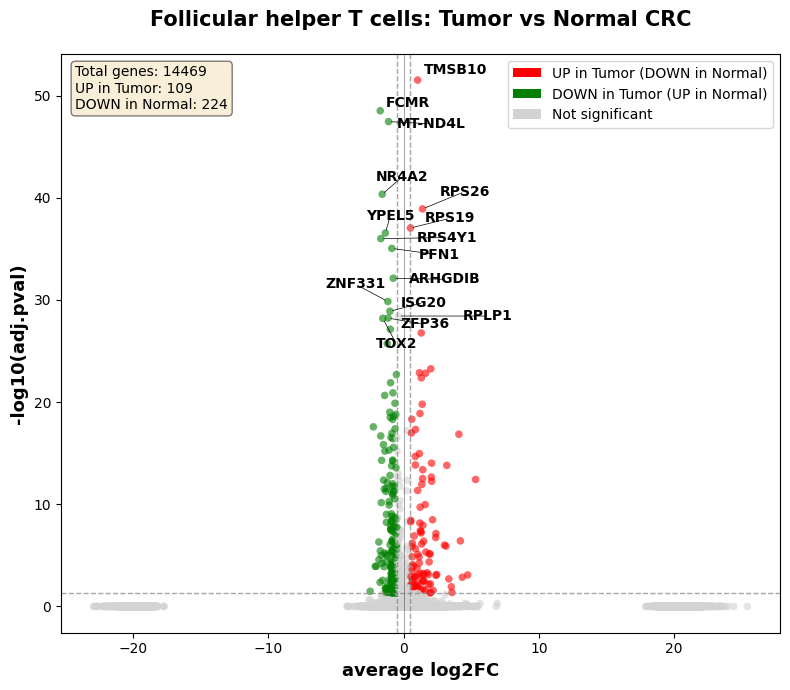


Follicular helper T cells:
  UP in Tumor (DOWN in Normal): 109
  DOWN in Tumor (UP in Normal): 224


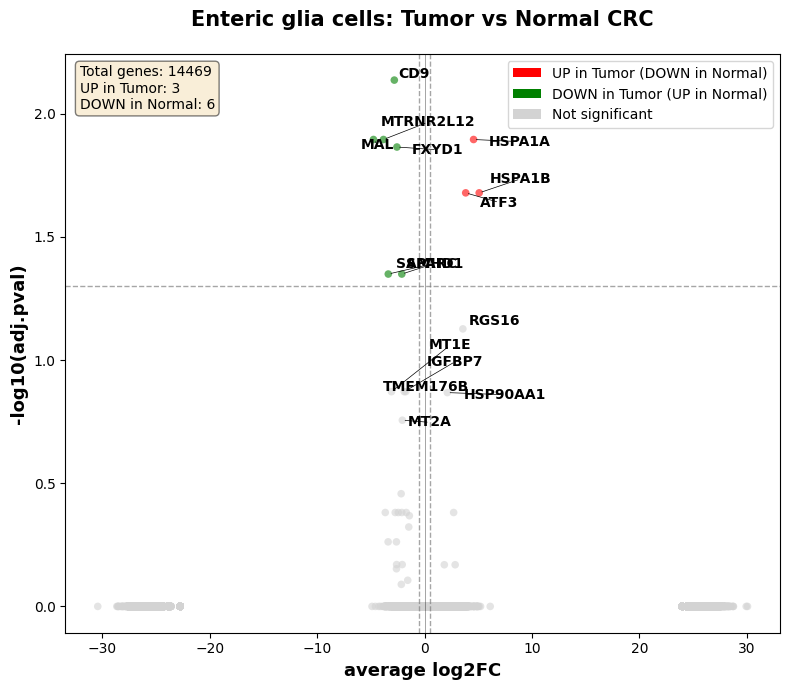


Enteric glia cells:
  UP in Tumor (DOWN in Normal): 3
  DOWN in Tumor (UP in Normal): 6


In [9]:
# Create individual volcano plot for each cell type
for cell_type in cell_types:
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Get DEGs for this cell type
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    if len(ct_degs) == 0:
        print(f"No DEGs found for {cell_type}")
        plt.close()
        continue
    
    # Calculate -log10(pval)
    ct_degs['-log10_pval'] = -np.log10(ct_degs['pvals_adj'] + 1e-300)
    
    # Color by significance
    colors = []
    for _, row in ct_degs.iterrows():
        if row['pvals_adj'] < 0.05 and abs(row['logfoldchanges']) > 0.5:
            if row['logfoldchanges'] > 0:
                colors.append('red')  # UP in left (DOWN in right)
            else:
                colors.append('green')  # DOWN in left (UP in right)
        else:
            colors.append('lightgray')
    
    # Volcano plot
    scatter = ax.scatter(
        ct_degs['logfoldchanges'],
        ct_degs['-log10_pval'],
        c=colors,
        alpha=0.6,
        s=30,
        edgecolors='none'
    )

    # Label top genes with adjustText for better readability
    texts = []
    top_genes = ct_degs.nlargest(15, '-log10_pval')  # Get top 15
    
    for _, gene in top_genes.iterrows():
        texts.append(
            ax.text(
                gene['logfoldchanges'],
                gene['-log10_pval'],
                gene['names'],
                fontsize=10,
                fontweight='bold'
            )
        )
    
    # Adjust text to avoid overlaps (requires adjustText package)
    # If you don't have it: pip install adjustText
    try:
        from adjustText import adjust_text
        adjust_text(
            texts,
            arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
            expand_points=(1.5, 1.5),
            force_points=(0.5, 0.5)
        )
    except ImportError:
        print("Install adjustText for better label placement: pip install adjustText")
    
    # Formatting
    ax.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('average log2FC', fontsize=13, fontweight='bold')
    ax.set_ylabel('-log10(adj.pval)', fontsize=13, fontweight='bold')
    ax.set_title(f'{cell_type}: Tumor vs Normal CRC', fontsize=15, fontweight='bold', pad=20)

    # Add legend with clearer labels
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='UP in Tumor (DOWN in Normal)'),
        Patch(facecolor='green', label='DOWN in Tumor (UP in Normal)'),
        Patch(facecolor='lightgray', label='Not significant')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True)
    
    # Add text box with summary statistics
    n_up = sum([1 for c in colors if c == 'red'])
    n_down = sum([1 for c in colors if c == 'green'])
    n_total = len(ct_degs)
    
    textstr = f'Total genes: {n_total}\nUP in Tumor: {n_up}\nDOWN in Normal: {n_down}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig(f'volcano_{cell_type.replace(" ", "_").replace("/", "_")}.pdf', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{cell_type}:")
    print(f"  UP in Tumor (DOWN in Normal): {n_up}")
    print(f"  DOWN in Tumor (UP in Normal): {n_down}")

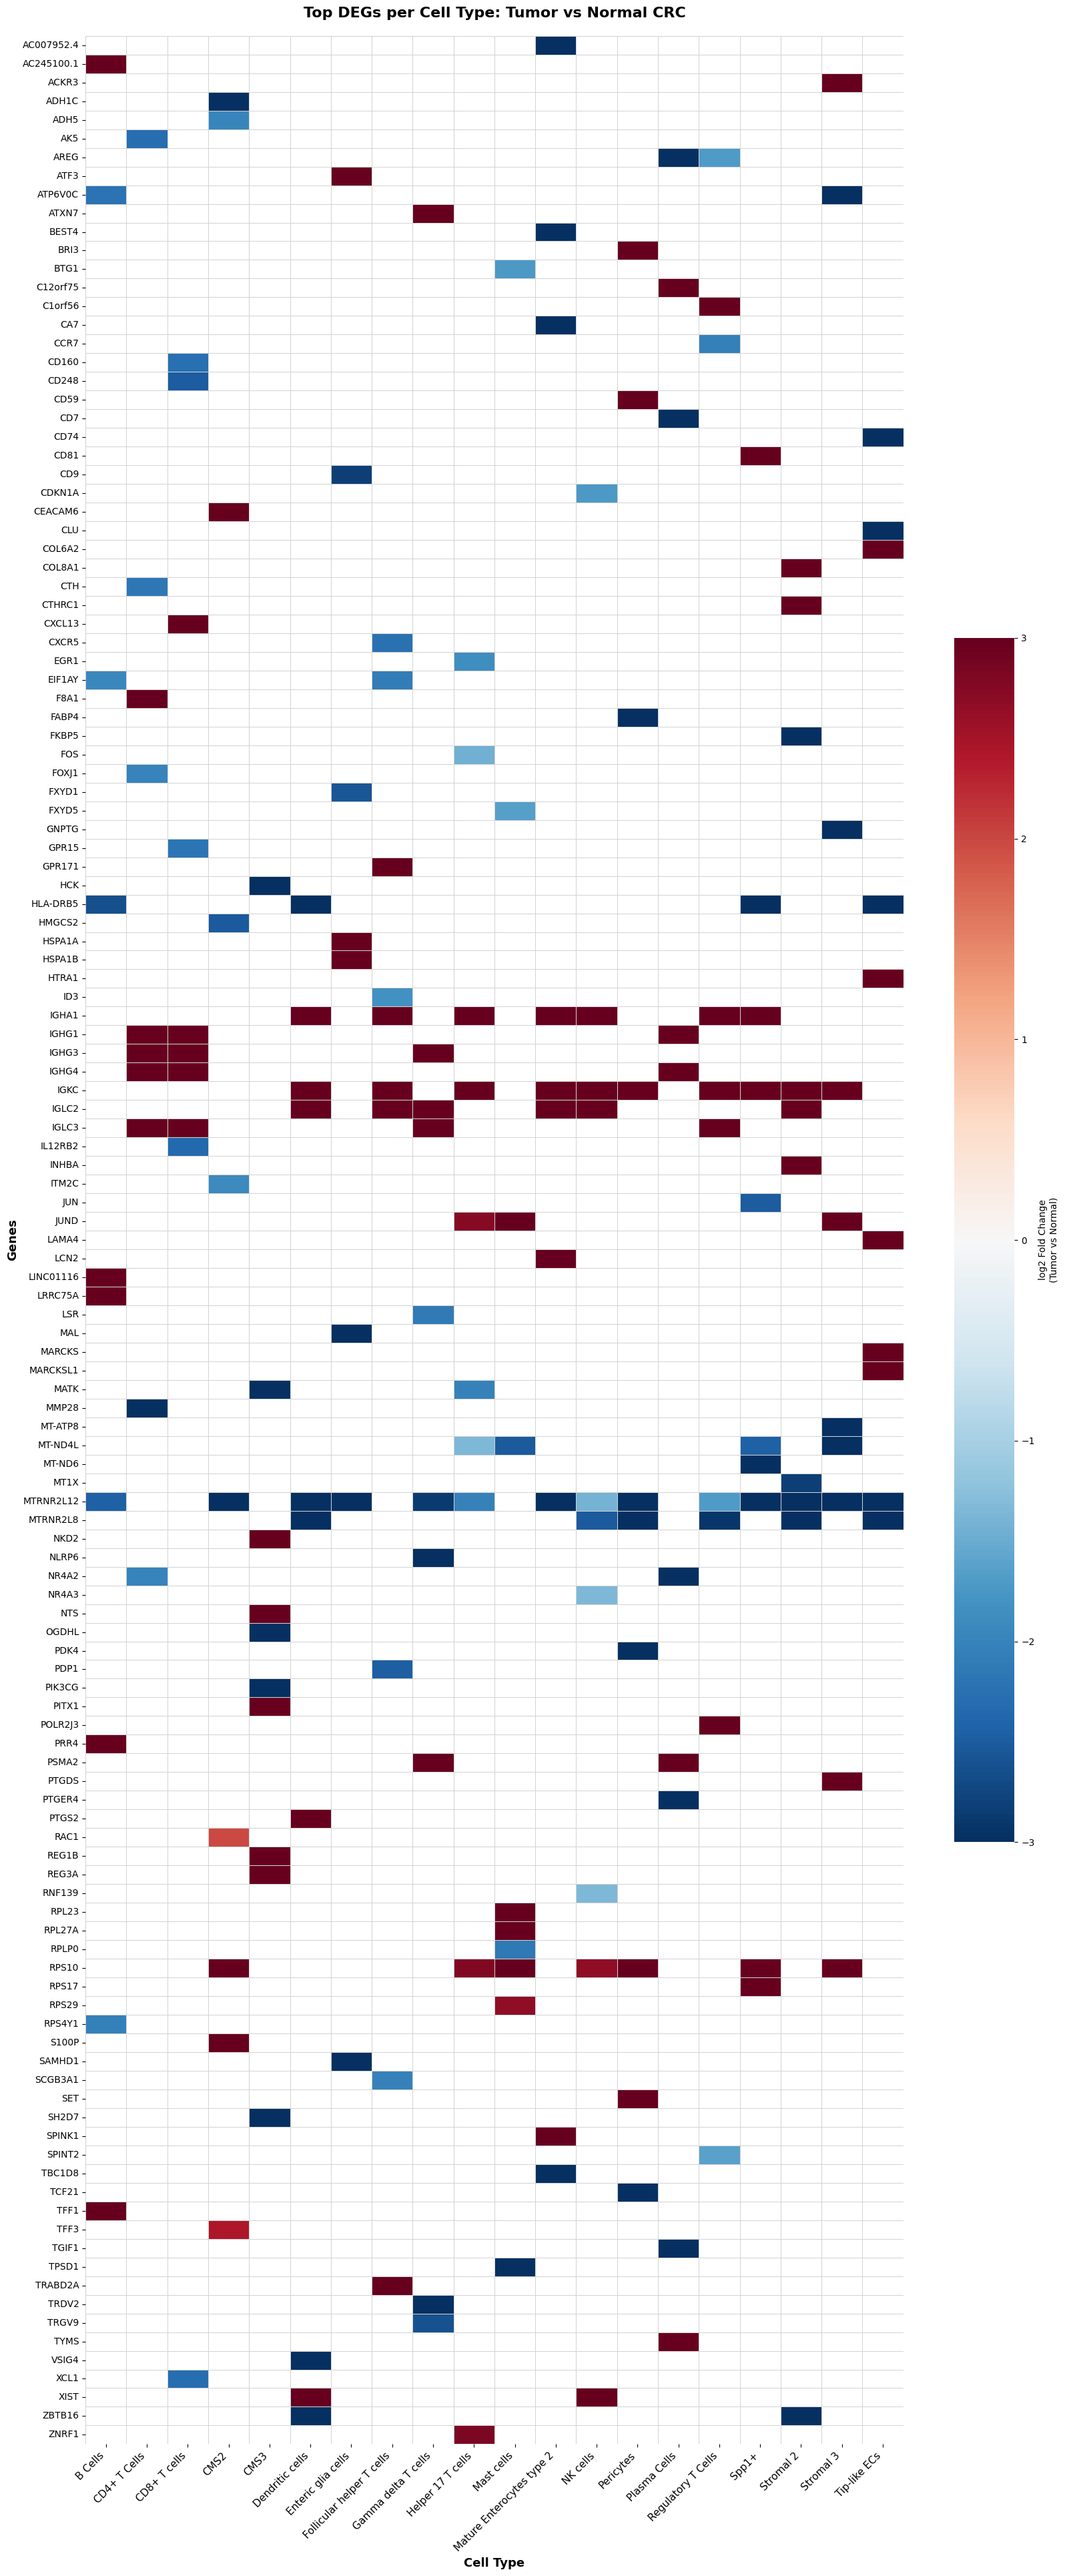


Total unique genes: 129
Cell types: 20

Genes per cell type:
  B Cells: 10 genes
  CD4+ T Cells: 10 genes
  CD8+ T cells: 10 genes
  CMS2: 10 genes
  CMS3: 10 genes
  Dendritic cells: 10 genes
  Enteric glia cells: 8 genes
  Follicular helper T cells: 10 genes
  Gamma delta T cells: 10 genes
  Helper 17 T cells: 10 genes
  Mast cells: 10 genes
  Mature Enterocytes type 2: 10 genes
  NK cells: 10 genes
  Pericytes: 10 genes
  Plasma Cells: 10 genes
  Regulatory T Cells: 10 genes
  Spp1+: 10 genes
  Stromal 2: 10 genes
  Stromal 3: 10 genes
  Tip-like ECs: 10 genes


In [10]:
# Collect top genes for each cell type
top_genes_per_celltype = []

for cell_type in cell_types:
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    # Filter significant genes
    sig_degs = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (abs(ct_degs['logfoldchanges']) > 0.5)
    ].copy()
    
    if len(sig_degs) == 0:
        continue
    
    # Get top 5 UP and top 5 DOWN genes
    up_genes = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(5, 'logfoldchanges')
    down_genes = sig_degs[sig_degs['logfoldchanges'] < 0].nsmallest(5, 'logfoldchanges')
    
    # Combine
    for _, gene in up_genes.iterrows():
        top_genes_per_celltype.append({
            'Gene': gene['names'],
            'Cell_Type': cell_type,
            'log2FC': gene['logfoldchanges']
        })
    
    for _, gene in down_genes.iterrows():
        top_genes_per_celltype.append({
            'Gene': gene['names'],
            'Cell_Type': cell_type,
            'log2FC': gene['logfoldchanges']
        })
# Create dataframe
df_heatmap = pd.DataFrame(top_genes_per_celltype)

# Pivot: Genes as rows, Cell types as columns
heatmap_pivot = df_heatmap.pivot_table(
    index='Gene',
    columns='Cell_Type',
    values='log2FC',
    aggfunc='first'  # In case same gene appears multiple times
)

# Remove genes that appear in too few cell types (optional)
# Keep genes that appear in at least 1 cell type (they all will)
heatmap_pivot = heatmap_pivot.dropna(how='all')

# Create the plot
fig, ax = plt.subplots(figsize=(len(cell_types) * 0.8, len(heatmap_pivot) * 0.3))

# Plot heatmap
sns.heatmap(
    heatmap_pivot,
    cmap='RdBu_r',
    center=0,
    vmin=-3,
    vmax=3,
    cbar_kws={'label': 'log2 Fold Change\n(Tumor vs Normal)', 'shrink': 0.5},
    linewidths=0.5,
    linecolor='lightgray',
    yticklabels=True,
    xticklabels=True,
    ax=ax,
    square=False,
    cbar_ax=None
)
# Formatting
ax.set_title('Top DEGs per Cell Type: Tumor vs Normal CRC', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cell Type', fontsize=13, fontweight='bold')
ax.set_ylabel('Genes', fontsize=13, fontweight='bold')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.tight_layout()
plt.savefig('heatmap_top_genes_all_celltypes.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal unique genes: {len(heatmap_pivot)}")
print(f"Cell types: {len(heatmap_pivot.columns)}")
print(f"\nGenes per cell type:")
for ct in heatmap_pivot.columns:
    n_genes = heatmap_pivot[ct].notna().sum()
    print(f"  {ct}: {n_genes} genes")

In [ ]:
# Specify the cell type
cell_type = 'CD4+ T Cells'

print(f"Creating heatmap for {cell_type}...")

# Get DEGs for this cell type
ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()

# Filter significant genes
sig_degs = ct_degs[
    (ct_degs['pvals_adj'] < 0.05) & 
    (abs(ct_degs['logfoldchanges']) > 0.5)
].copy()

print(f"Significant DEGs found: {len(sig_degs)}")

# Get top 25 UP and top 25 DOWN genes
up_genes = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(25, 'logfoldchanges')
down_genes = sig_degs[sig_degs['logfoldchanges'] < 0].nsmallest(25, 'logfoldchanges')

print(f"UP genes: {len(up_genes)}, DOWN genes: {len(down_genes)}")

# Combine genes ordered by log2FC (high to low)
top_genes = pd.concat([up_genes, down_genes]).sort_values('logfoldchanges', ascending=False)
gene_list = top_genes['names'].tolist()

print(f"Total genes to plot: {len(gene_list)}")

# Create a dataframe with log2FC values for left and right
# For Left: positive log2FC means UP in left, so we use the log2FC as is
# For Right: we flip the sign (negative of log2FC)
heatmap_data = pd.DataFrame({
    'Left CRC': top_genes.set_index('names')['logfoldchanges'],
    'Right CRC': -top_genes.set_index('names')['logfoldchanges']  # Flip the sign
})
# Reorder by original gene order (high UP to high DOWN)
heatmap_data = heatmap_data.loc[gene_list]

# Count UP and DOWN genes
n_up = len(up_genes)
n_down = len(down_genes)

# Get cell counts (if you want to display them)
cell_mask = adata.obs['Cell_Type'] == cell_type
adata_celltype = adata[cell_mask, :]
n_left = (adata_celltype.obs['location'] == 'Left').sum()
n_right = (adata_celltype.obs['location'] == 'Right').sum()

# Create figure
fig, ax = plt.subplots(figsize=(10, max(12, len(gene_list) * 0.3)))

# Plot heatmap with log2FC values
sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=0,
    vmin=-3,
    vmax=3,
    cbar_kws={'label': 'log2 Fold Change\n(expression level)', 'shrink': 0.4},
    linewidths=0.5,
    linecolor='white',
    yticklabels=True,
    xticklabels=True,
    ax=ax
)

# Formatting
ax.set_title(f'{cell_type}\nTop {len(gene_list)} DEGs: Left vs Right CRC', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Location', fontsize=13, fontweight='bold')
ax.set_ylabel('Genes', fontsize=13, fontweight='bold')

# X-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

# Add dividing line between UP and DOWN genes
if n_up > 0 and n_down > 0:
    ax.axhline(y=n_up, color='black', linewidth=2.5, linestyle='--')
    
    # Add labels for UP/DOWN sections
    ax.text(-0.35, n_up/2, f'UP in Left\n({n_up})', 
            rotation=90, va='center', ha='right',
            fontsize=11, fontweight='bold', color='darkred')
    ax.text(-0.35, n_up + n_down/2, 
            f'DOWN in Left\n({n_down})', 
            rotation=90, va='center', ha='right',
            fontsize=11, fontweight='bold', color='darkblue')

# Add statistics box
textstr = f'Left: {n_left} cells\nRight: {n_right} cells\n\nUP: {n_up}\nDOWN: {n_down}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', bbox=props)

plt.tight_layout()
plt.savefig(f'heatmap_{cell_type.replace(" ", "_").replace("+", "plus")}_log2FC.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Heatmap created successfully!")
print(f"Plotted {len(gene_list)} genes")
print(f"\nColor legend:")
print(f"  Dark Red = Highly expressed in that location")
print(f"  Dark Blue = Lowly expressed in that location")
print(f"  White/Light = Similar expression between locations")

Found 20 cell types
Cell types: ['CD4+ T Cells', 'CMS3', 'Tip-like ECs', 'CD8+ T cells', 'B Cells', 'Spp1+', 'Mast cells', 'Stromal 2', 'CMS2', 'Regulatory T Cells', 'Pericytes', 'Dendritic cells', 'Gamma delta T cells', 'Helper 17 T cells', 'Mature Enterocytes type 2', 'NK cells', 'Plasma Cells', 'Stromal 3', 'Follicular helper T cells', 'Enteric glia cells']


Processing: CD4+ T Cells
Significant DEGs found: 1076
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=11933, Normal=5424


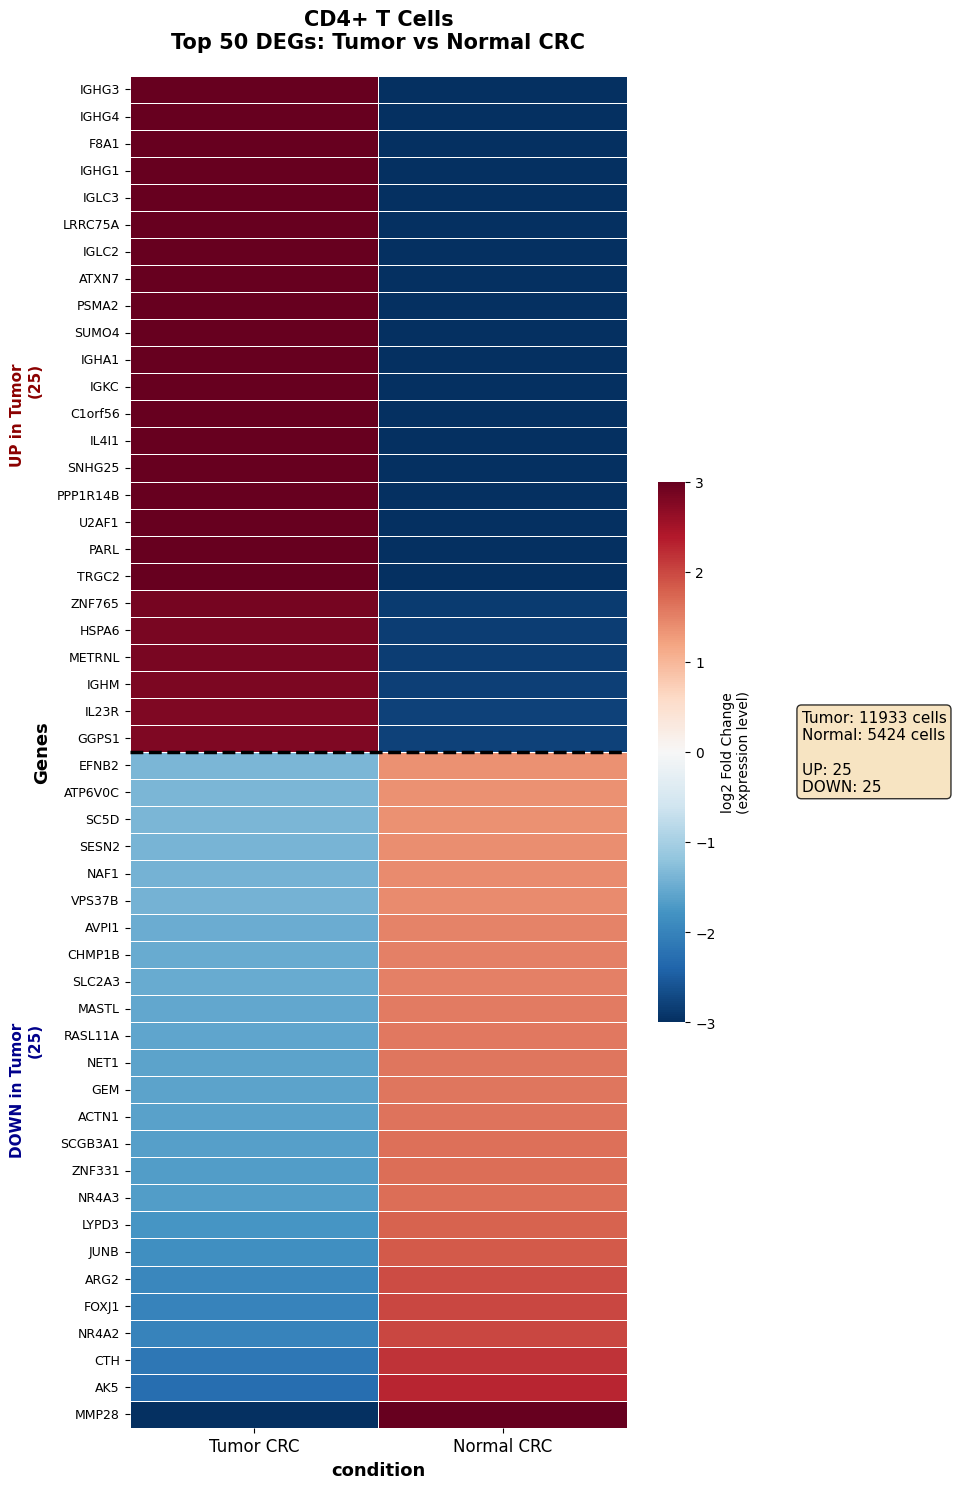

✅ Heatmap saved: heatmap_CD4plus_T_Cells_log2FC.pdf
Plotted 50 genes

Processing: CMS3
Significant DEGs found: 2422
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=2898, Normal=978


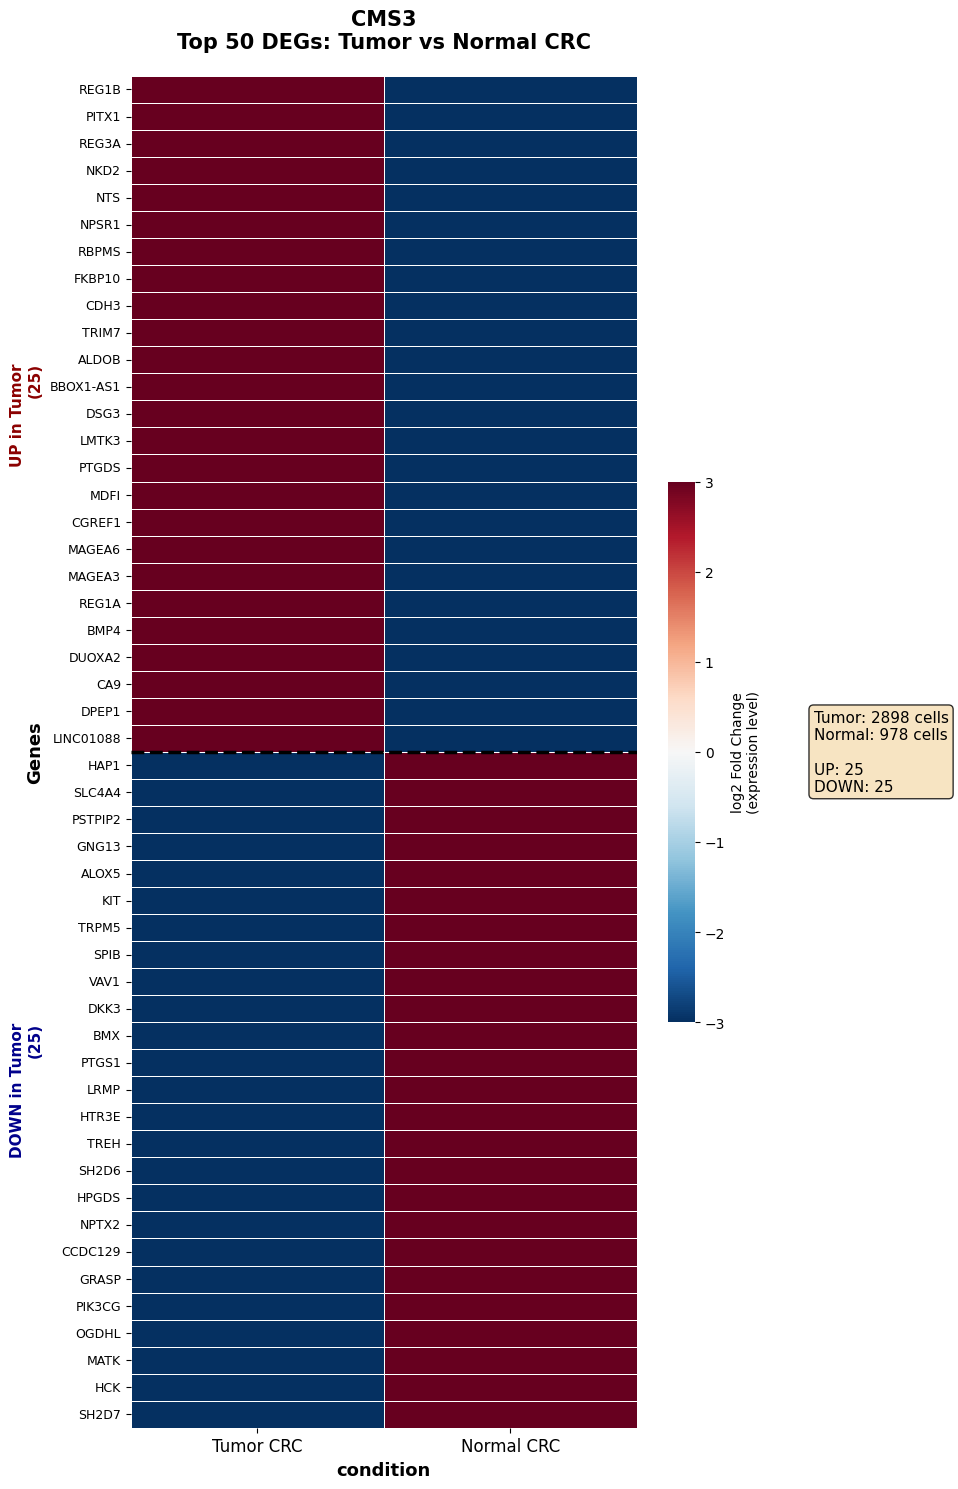

✅ Heatmap saved: heatmap_CMS3_log2FC.pdf
Plotted 50 genes

Processing: Tip-like ECs
Significant DEGs found: 48
UP genes: 21, DOWN genes: 25
Total genes to plot: 46
Cells: Tumor=581, Normal=29


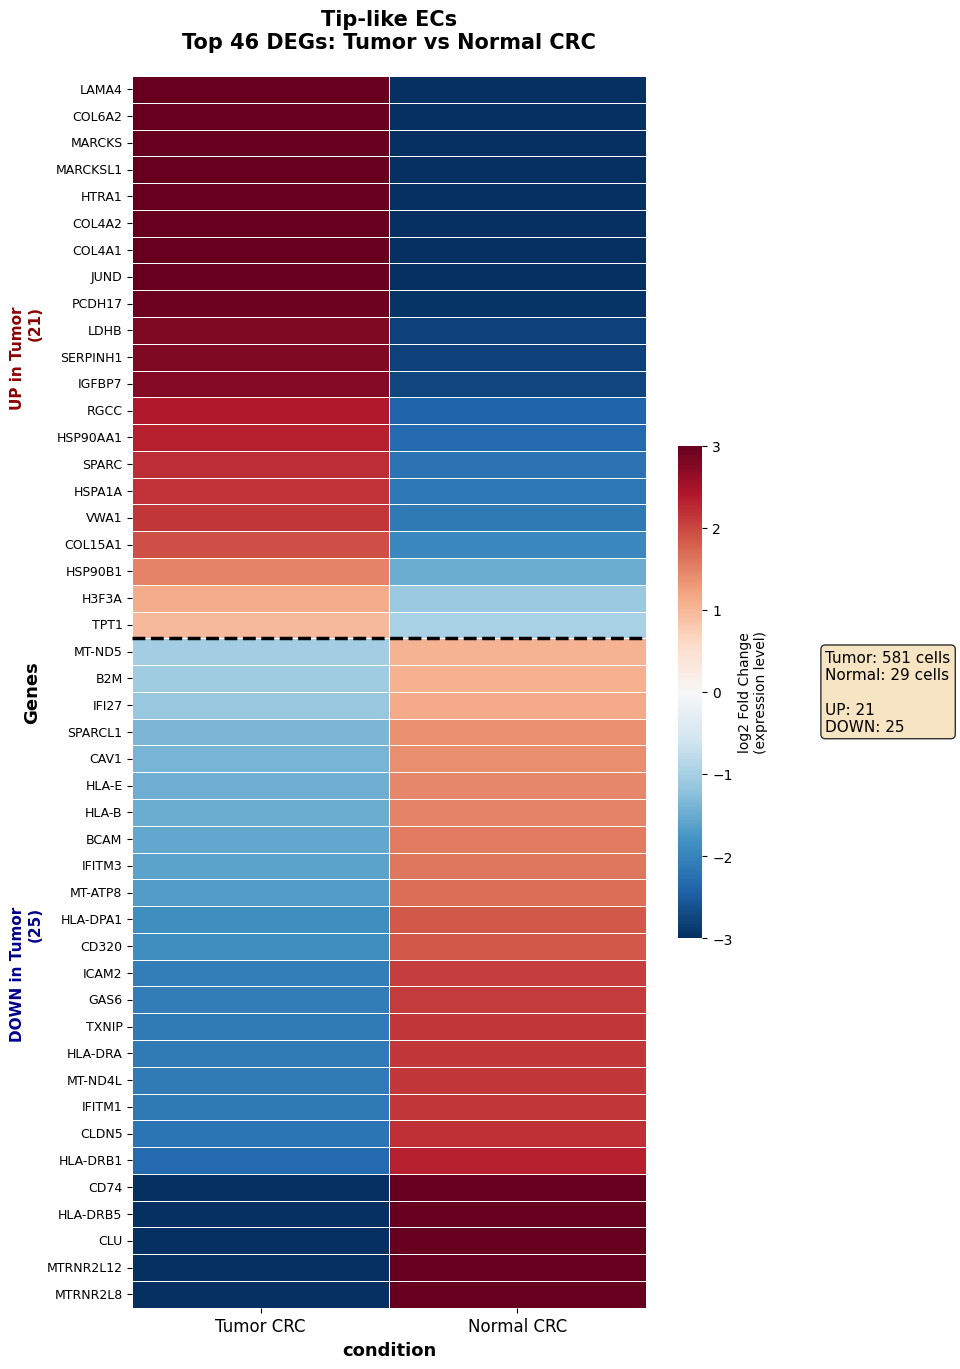

✅ Heatmap saved: heatmap_Tip-like_ECs_log2FC.pdf
Plotted 46 genes

Processing: CD8+ T cells
Significant DEGs found: 692
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=5055, Normal=1621


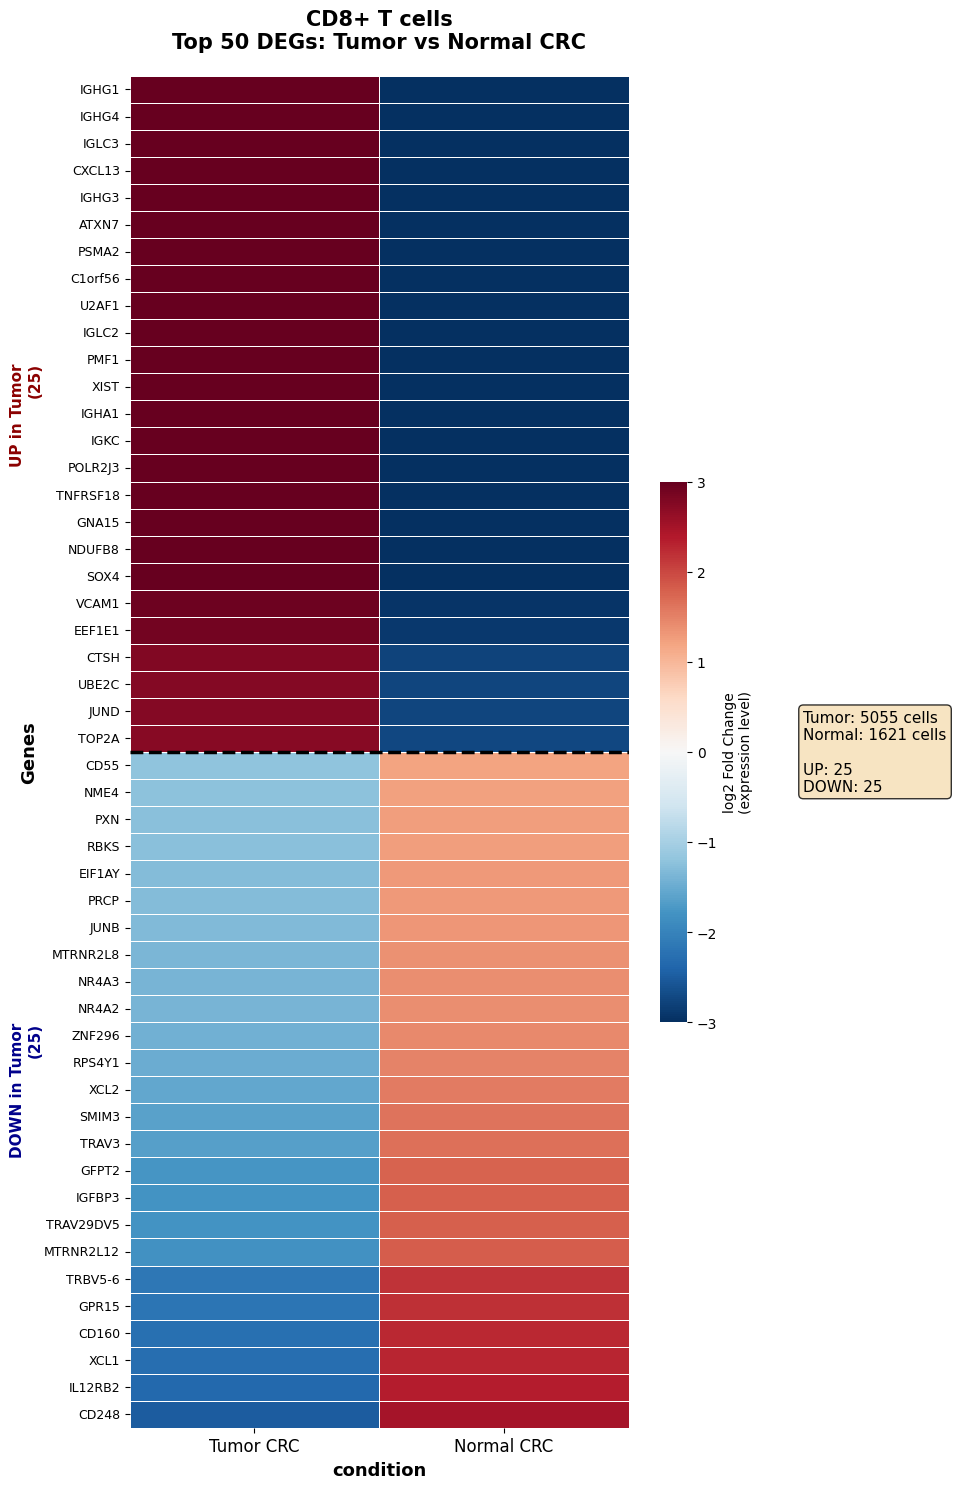

✅ Heatmap saved: heatmap_CD8plus_T_cells_log2FC.pdf
Plotted 50 genes

Processing: B Cells
Significant DEGs found: 1283
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=7021, Normal=3753


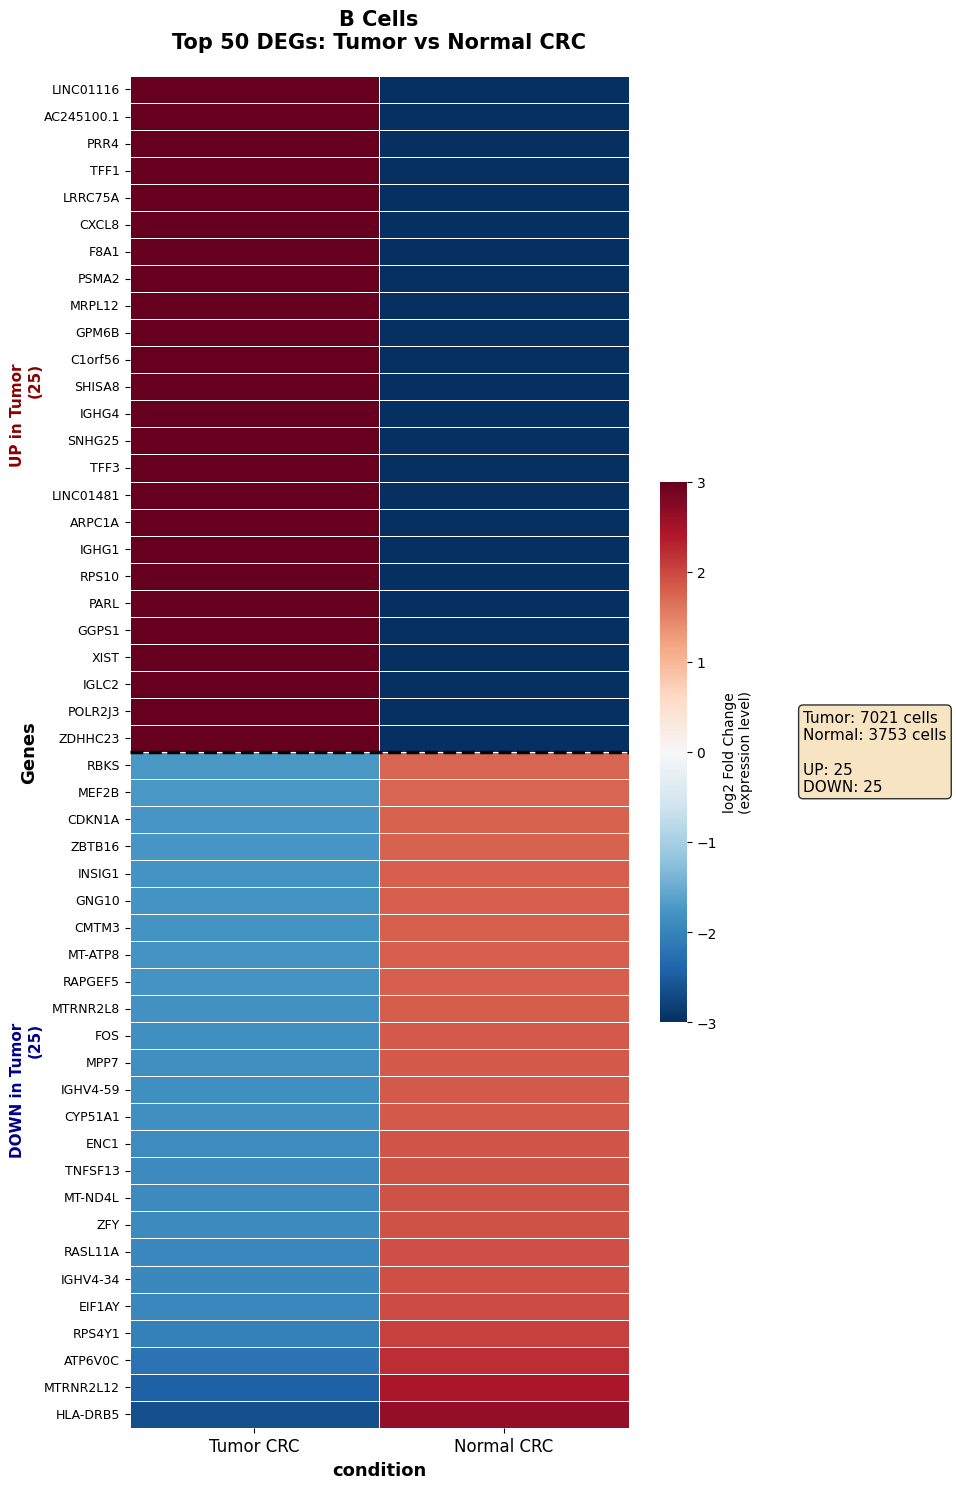

✅ Heatmap saved: heatmap_B_Cells_log2FC.pdf
Plotted 50 genes

Processing: Spp1+
Significant DEGs found: 55
UP genes: 16, DOWN genes: 25
Total genes to plot: 41
Cells: Tumor=1612, Normal=22


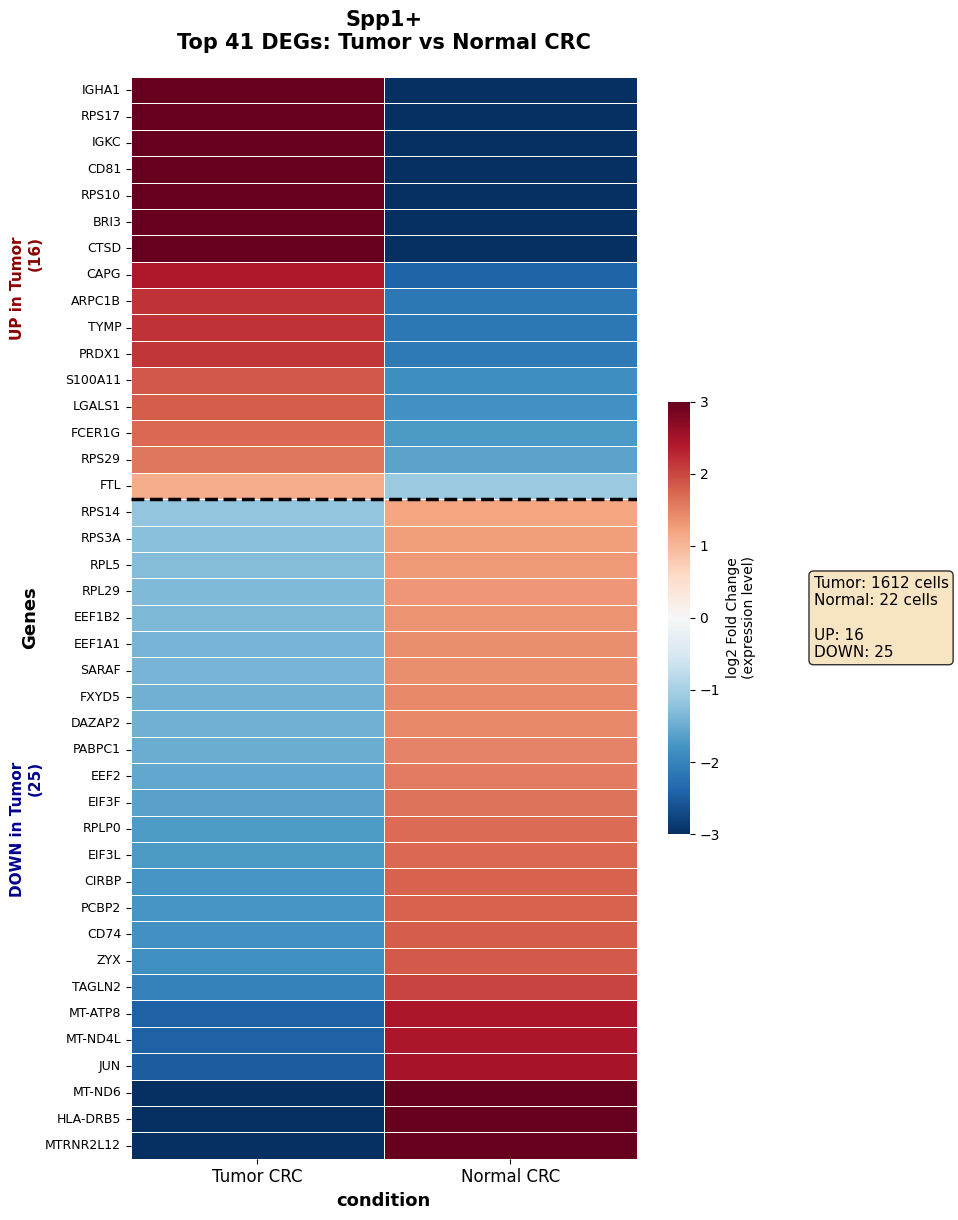

✅ Heatmap saved: heatmap_Spp1plus_log2FC.pdf
Plotted 41 genes

Processing: Mast cells
Significant DEGs found: 11
UP genes: 6, DOWN genes: 5
Total genes to plot: 11
Cells: Tumor=628, Normal=14


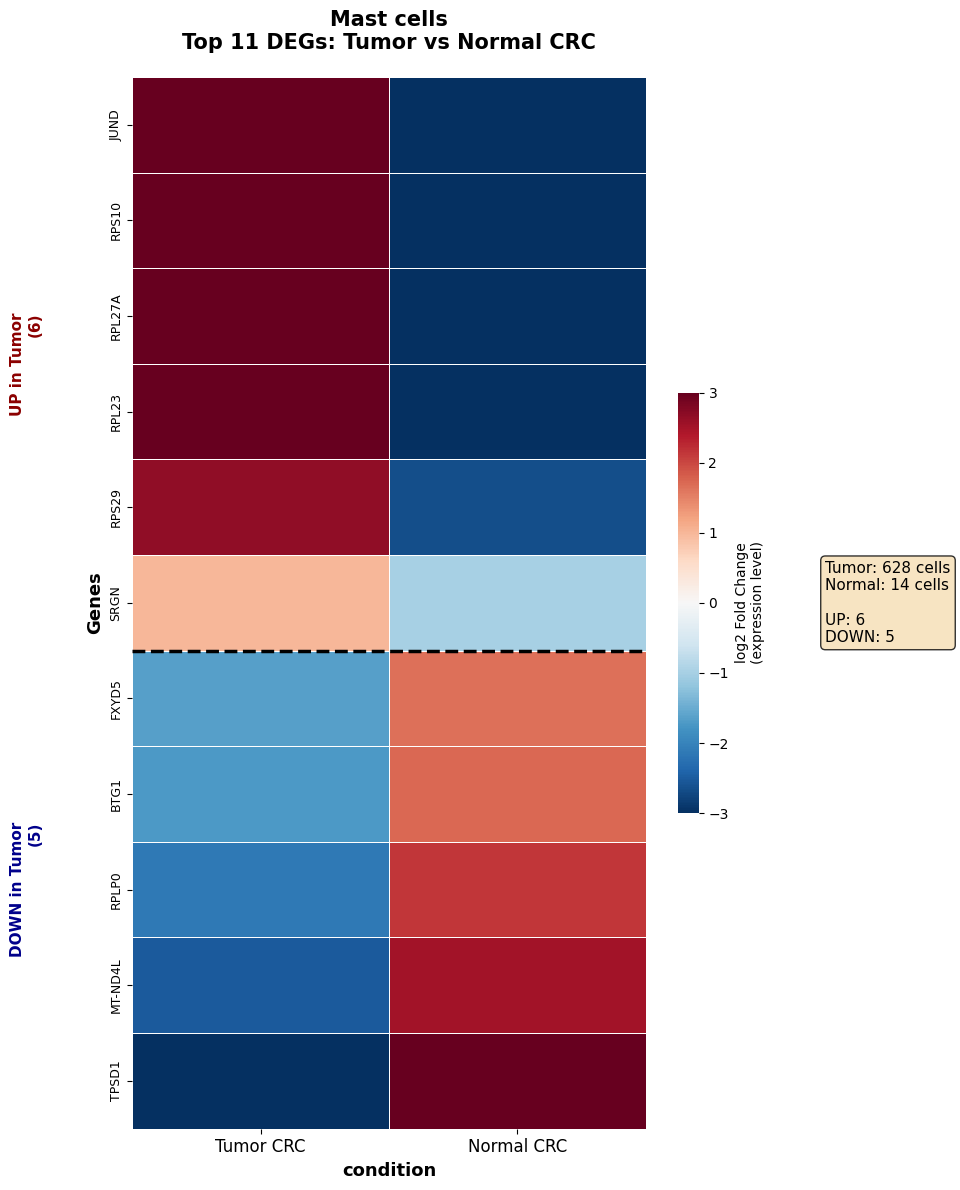

✅ Heatmap saved: heatmap_Mast_cells_log2FC.pdf
Plotted 11 genes

Processing: Stromal 2
Significant DEGs found: 122
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=849, Normal=48


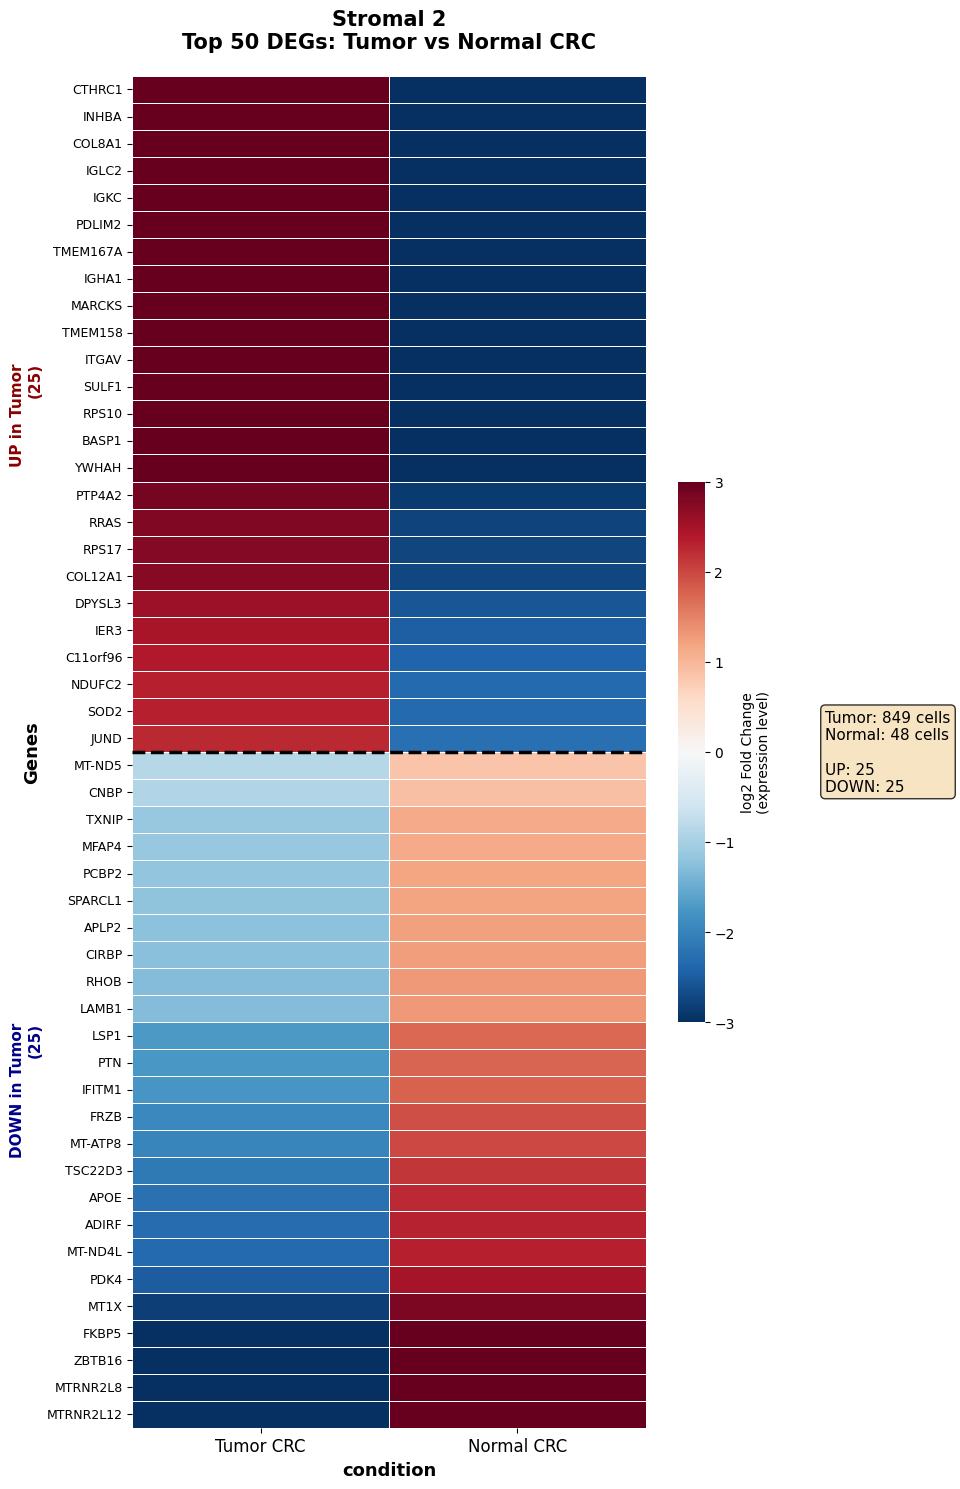

✅ Heatmap saved: heatmap_Stromal_2_log2FC.pdf
Plotted 50 genes

Processing: CMS2
Significant DEGs found: 21
UP genes: 11, DOWN genes: 10
Total genes to plot: 21
Cells: Tumor=1761, Normal=31


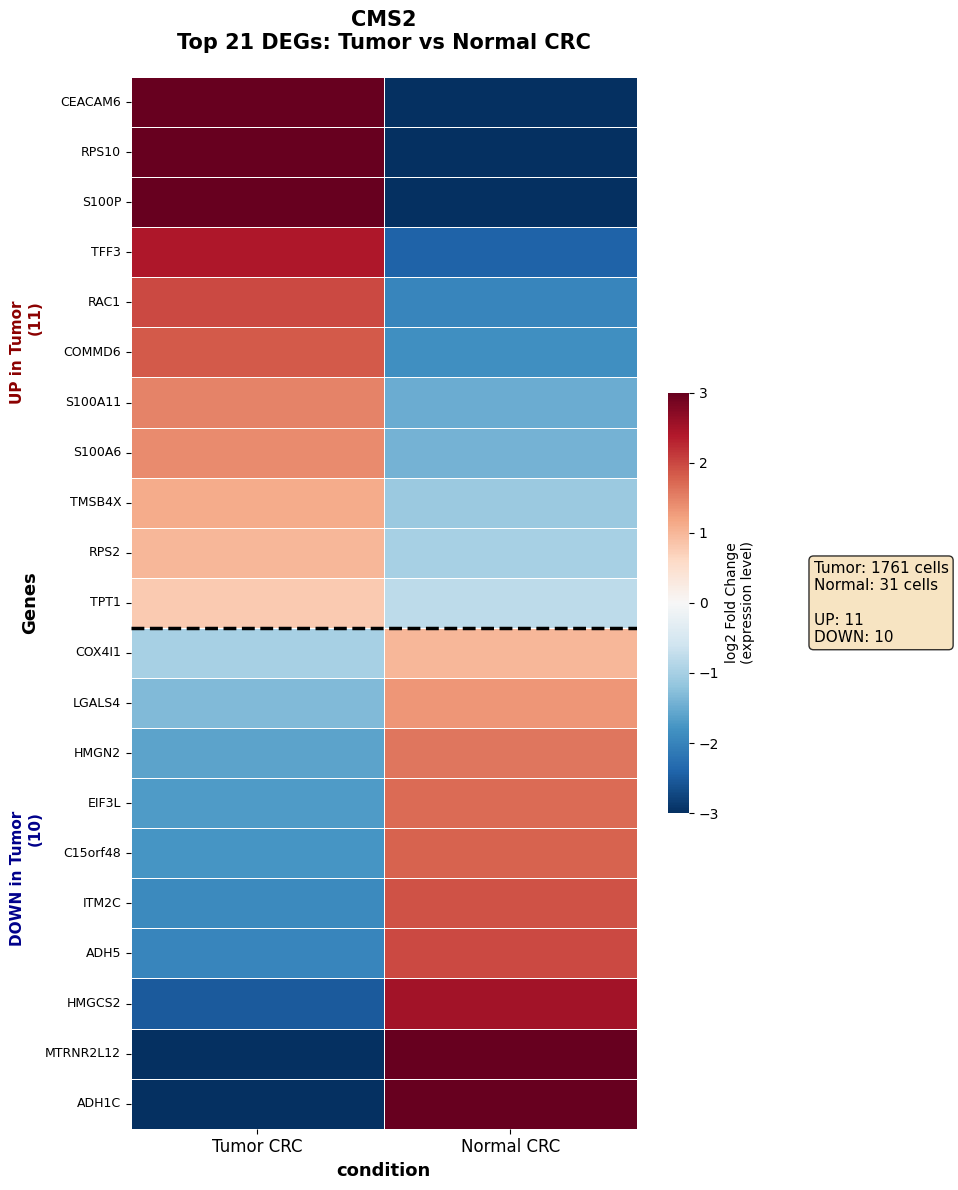

✅ Heatmap saved: heatmap_CMS2_log2FC.pdf
Plotted 21 genes

Processing: Regulatory T Cells
Significant DEGs found: 442
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=3536, Normal=371


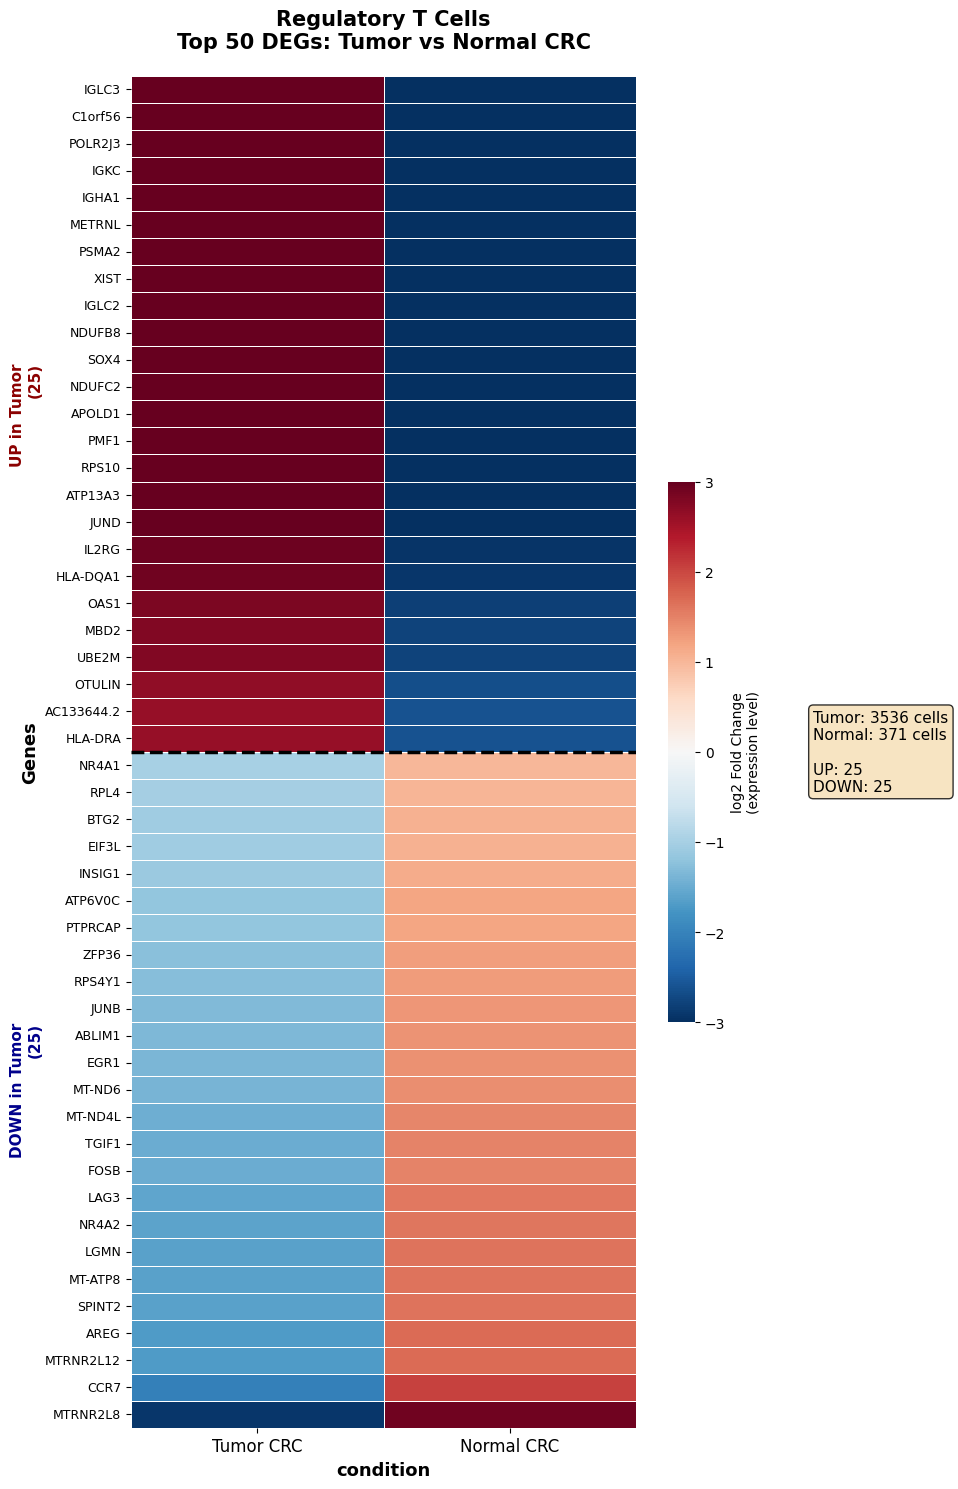

✅ Heatmap saved: heatmap_Regulatory_T_Cells_log2FC.pdf
Plotted 50 genes

Processing: Pericytes
Significant DEGs found: 24
UP genes: 13, DOWN genes: 11
Total genes to plot: 24
Cells: Tumor=434, Normal=23


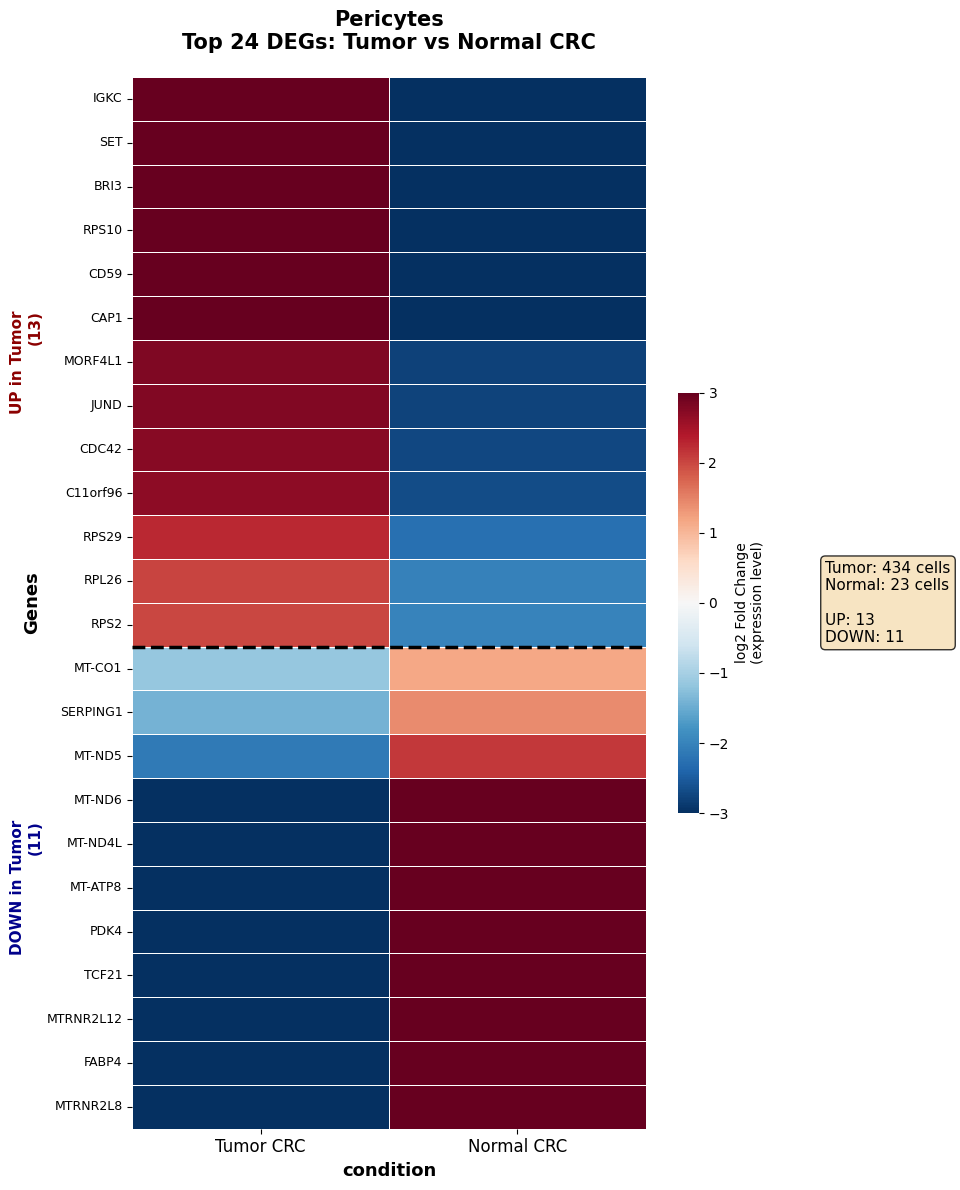

✅ Heatmap saved: heatmap_Pericytes_log2FC.pdf
Plotted 24 genes

Processing: Dendritic cells
Significant DEGs found: 273
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=2061, Normal=44


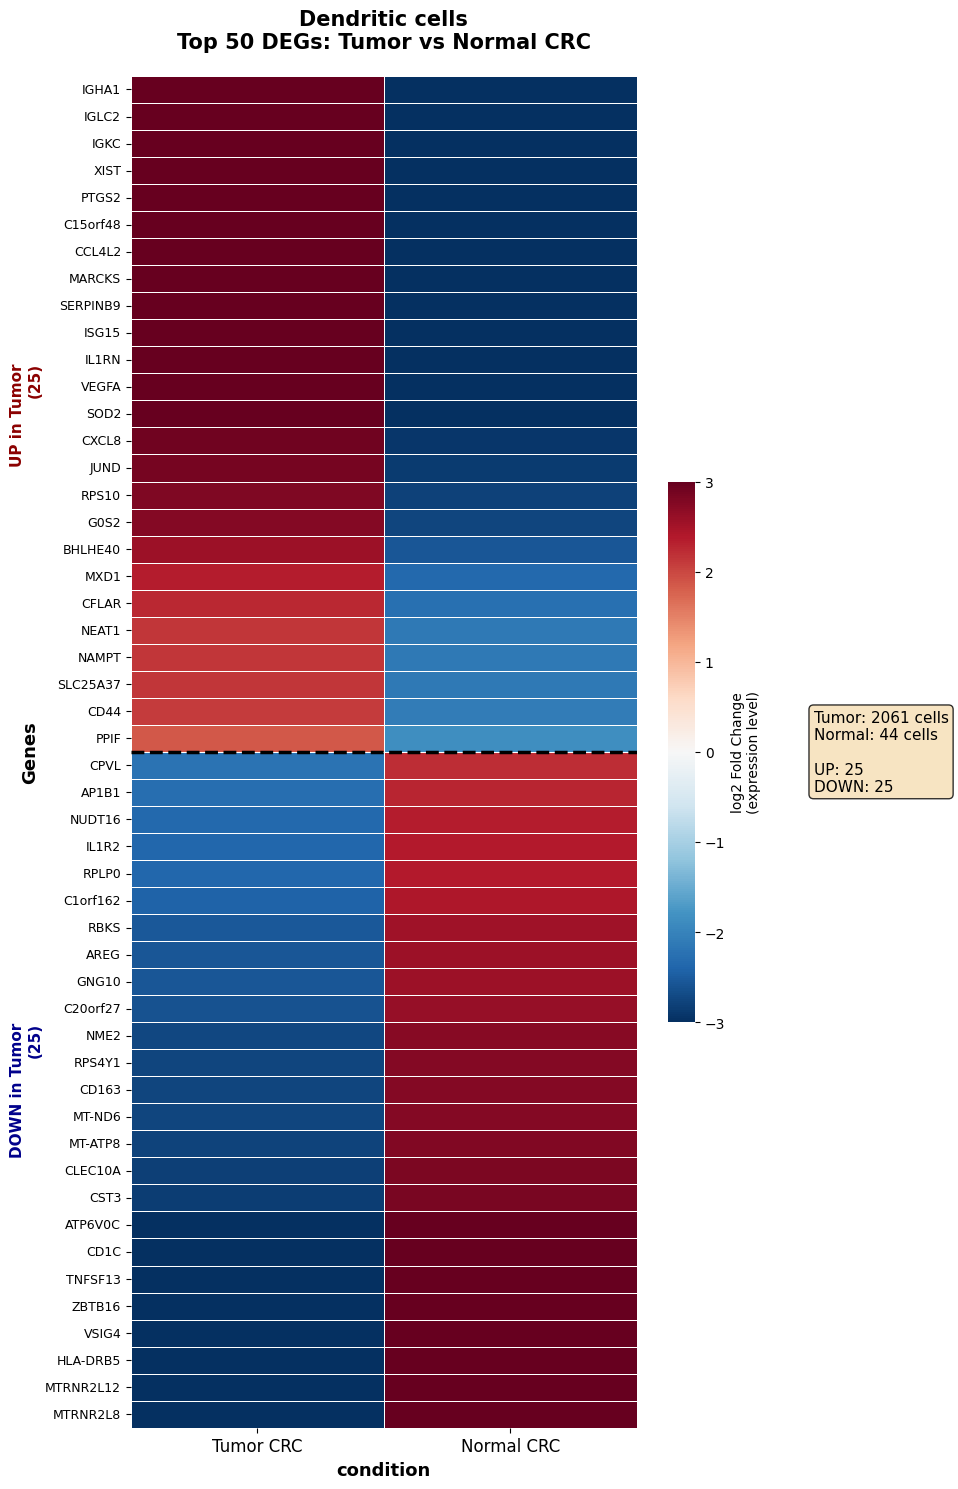

✅ Heatmap saved: heatmap_Dendritic_cells_log2FC.pdf
Plotted 50 genes

Processing: Gamma delta T cells
Significant DEGs found: 450
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=763, Normal=573


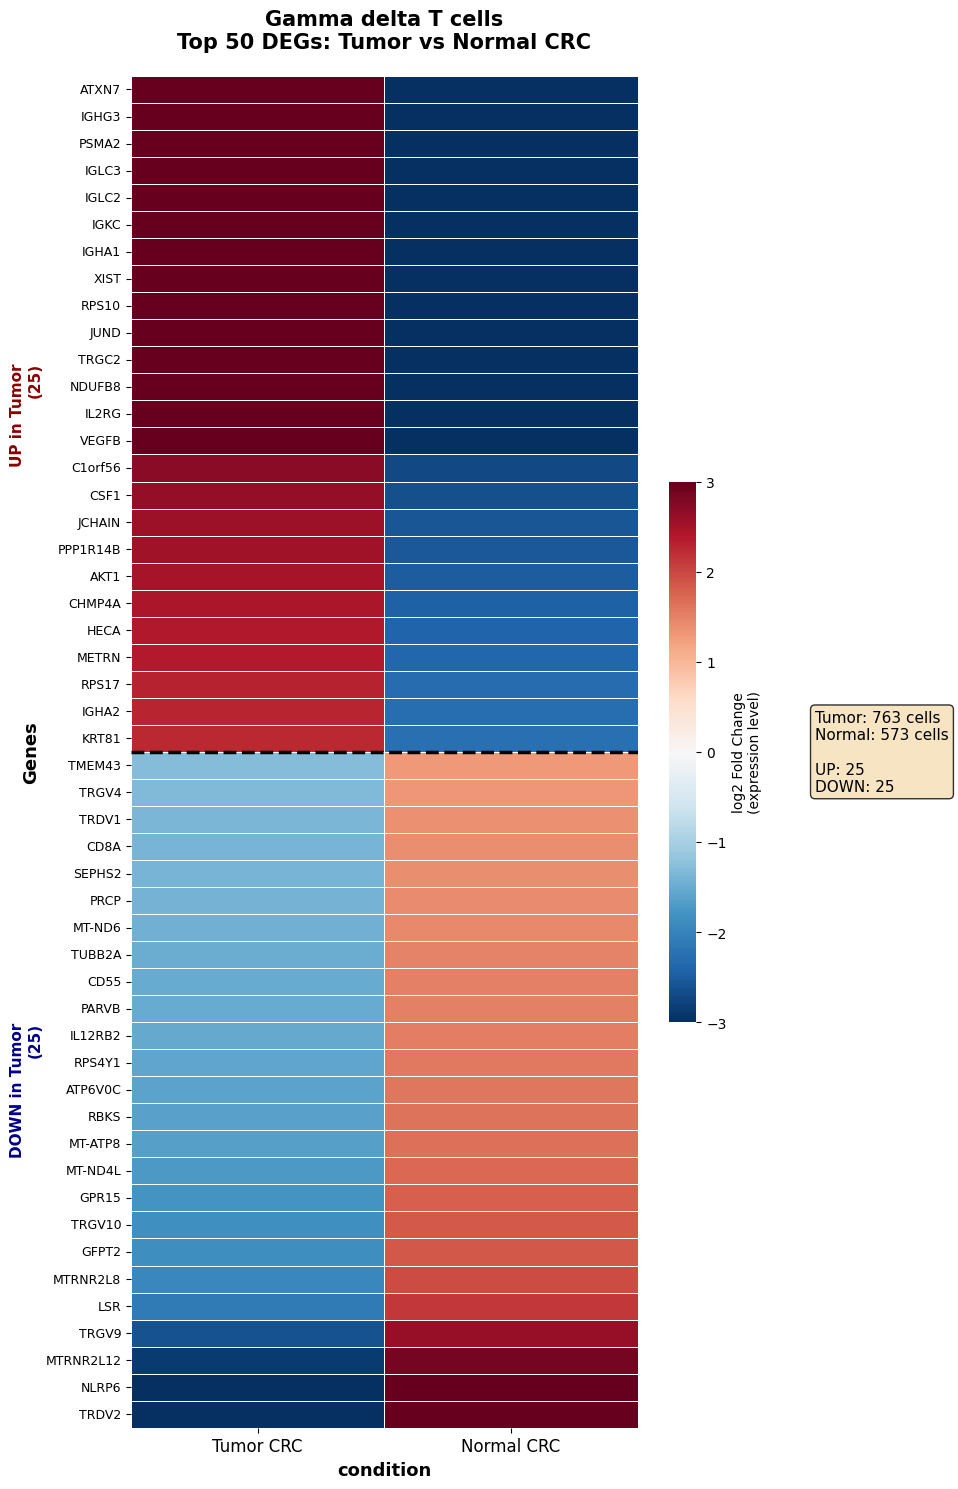

✅ Heatmap saved: heatmap_Gamma_delta_T_cells_log2FC.pdf
Plotted 50 genes

Processing: Helper 17 T cells
Significant DEGs found: 190
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=2267, Normal=110


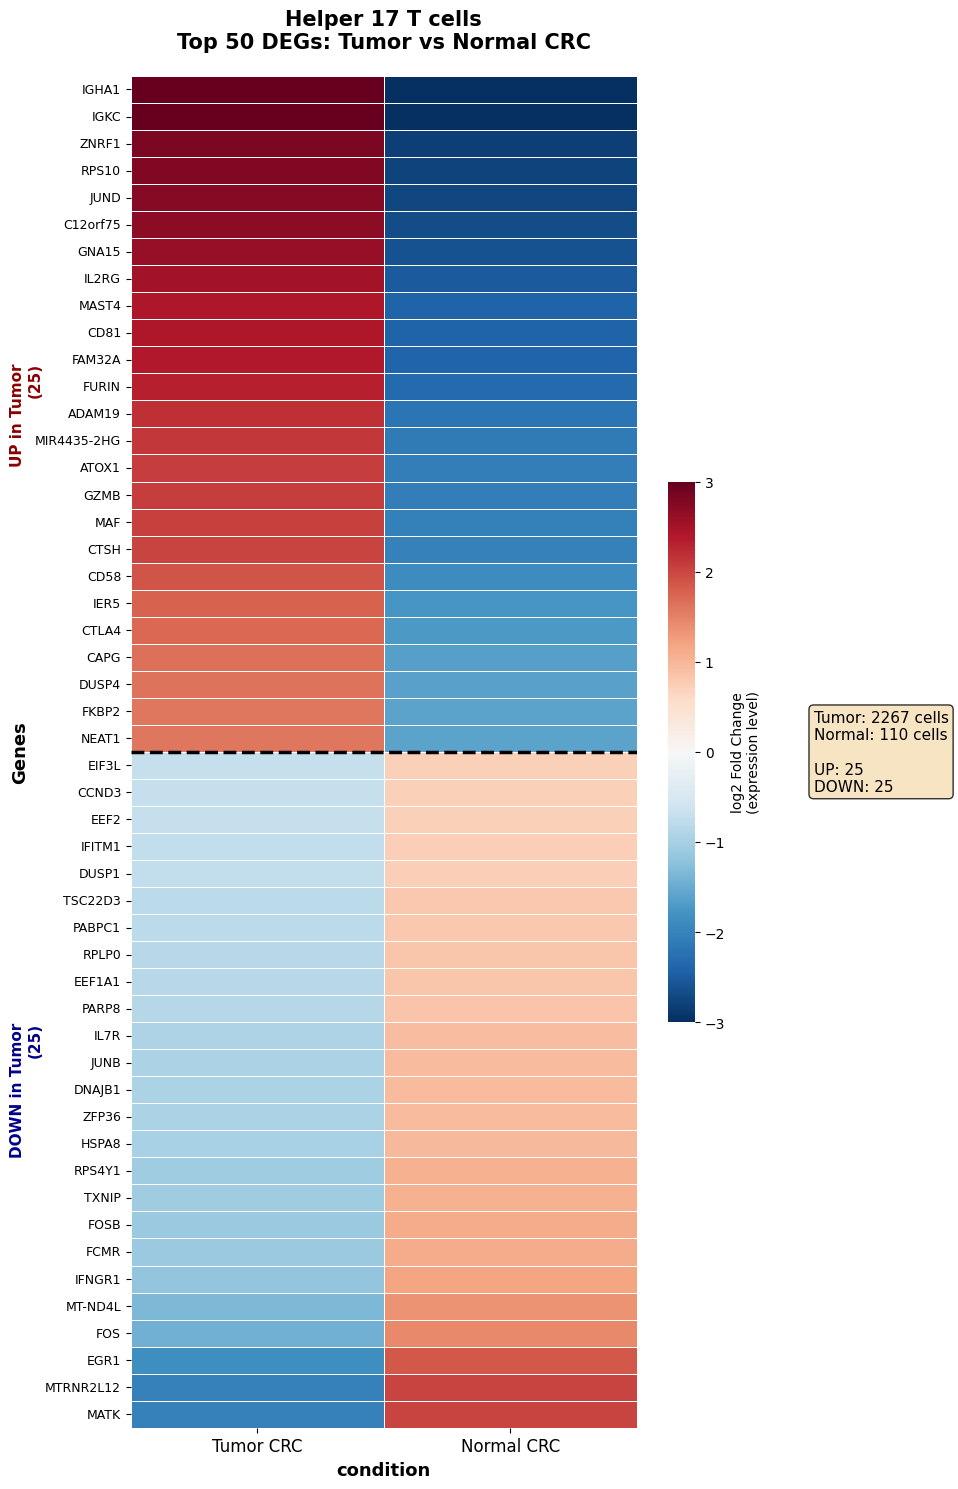

✅ Heatmap saved: heatmap_Helper_17_T_cells_log2FC.pdf
Plotted 50 genes

Processing: Mature Enterocytes type 2
Significant DEGs found: 261
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=205, Normal=121


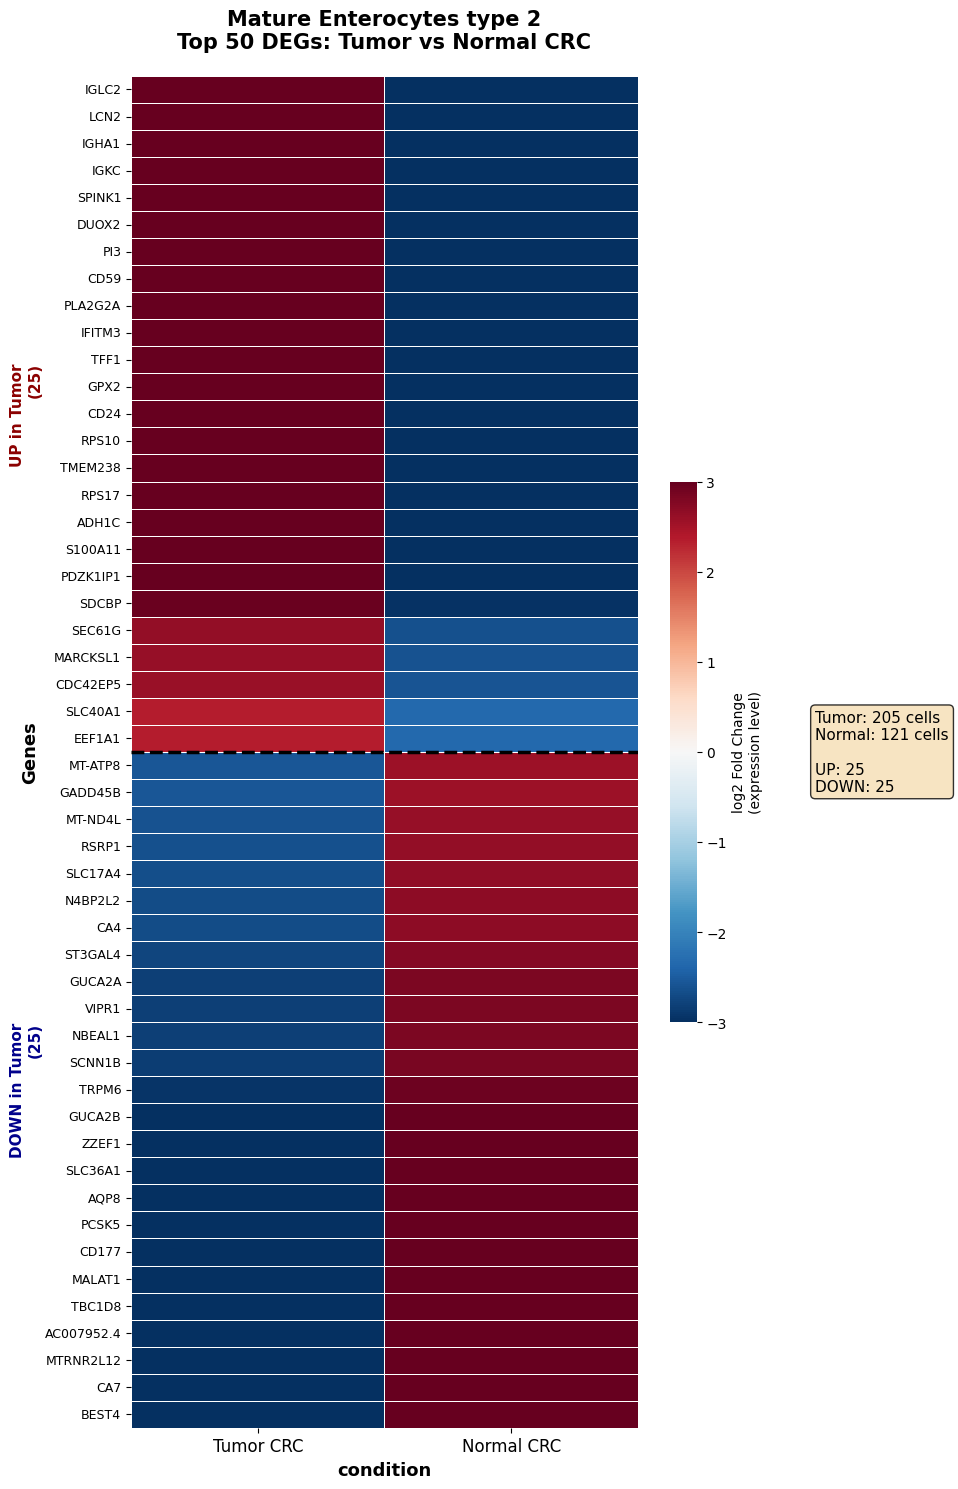

✅ Heatmap saved: heatmap_Mature_Enterocytes_type_2_log2FC.pdf
Plotted 50 genes

Processing: NK cells
Significant DEGs found: 114
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=1009, Normal=311


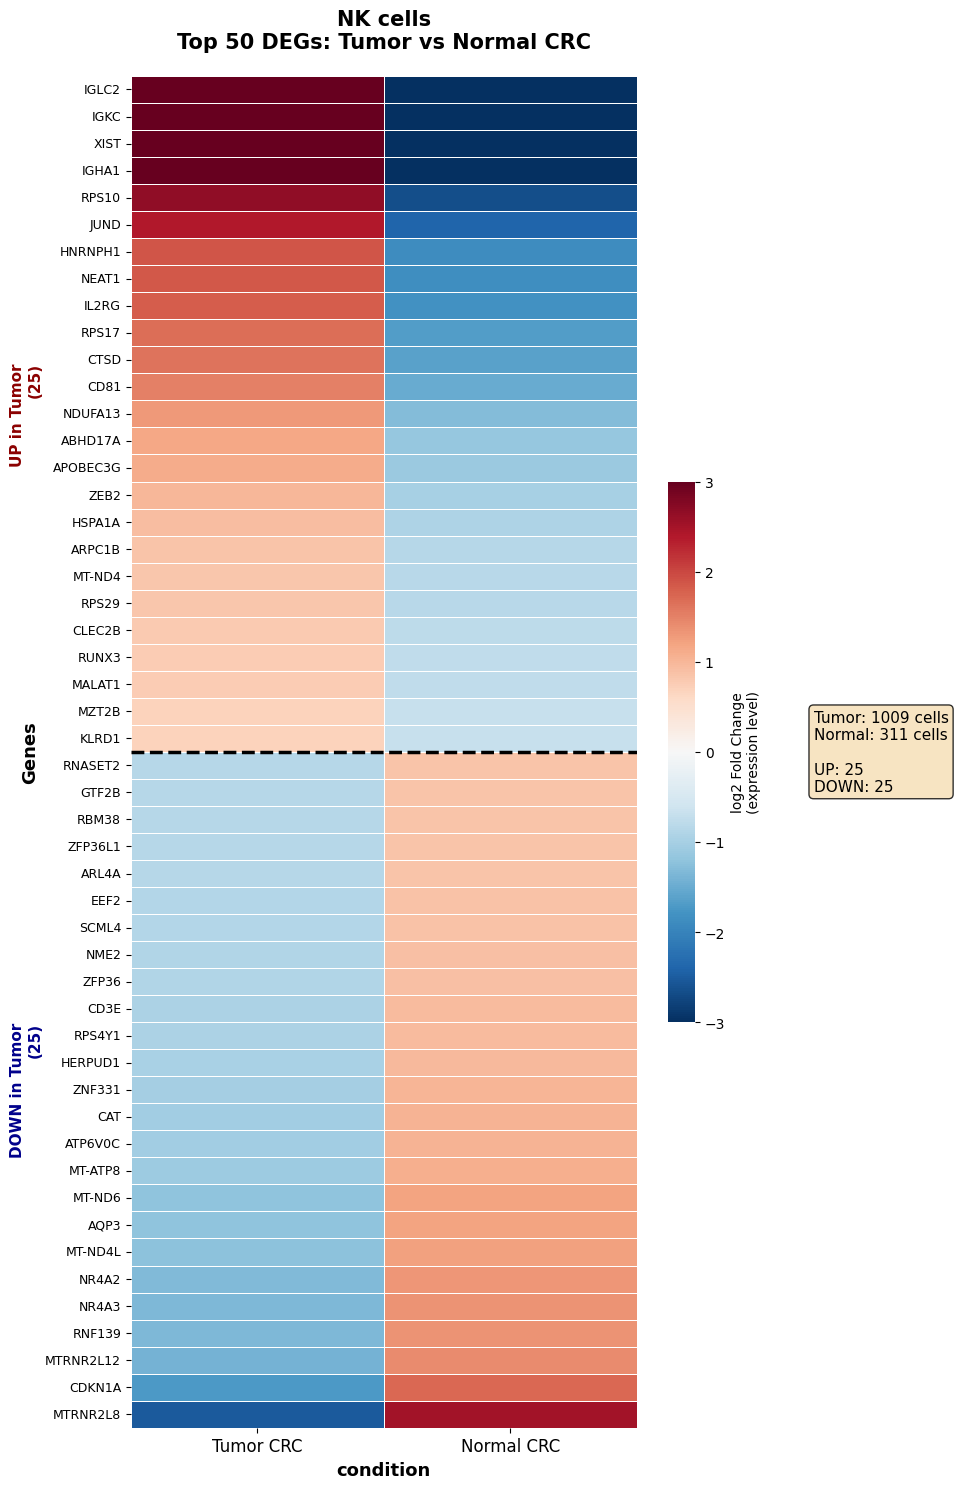

✅ Heatmap saved: heatmap_NK_cells_log2FC.pdf
Plotted 50 genes

Processing: Plasma Cells
Significant DEGs found: 229
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=199, Normal=41


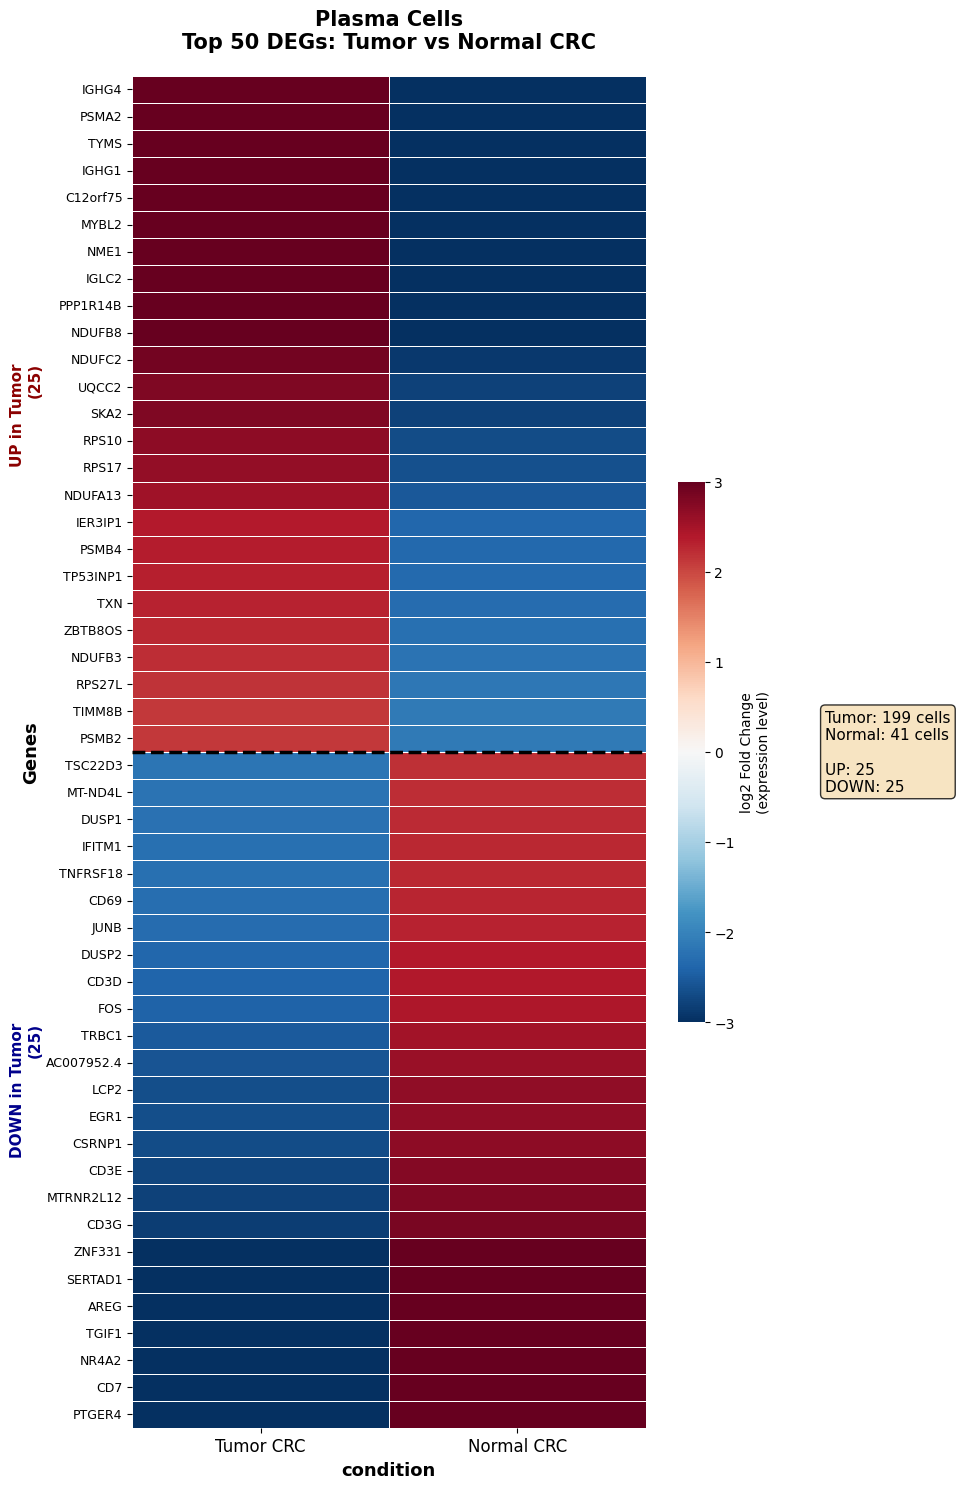

✅ Heatmap saved: heatmap_Plasma_Cells_log2FC.pdf
Plotted 50 genes

Processing: Stromal 3
Significant DEGs found: 59
UP genes: 21, DOWN genes: 25
Total genes to plot: 46
Cells: Tumor=23, Normal=42


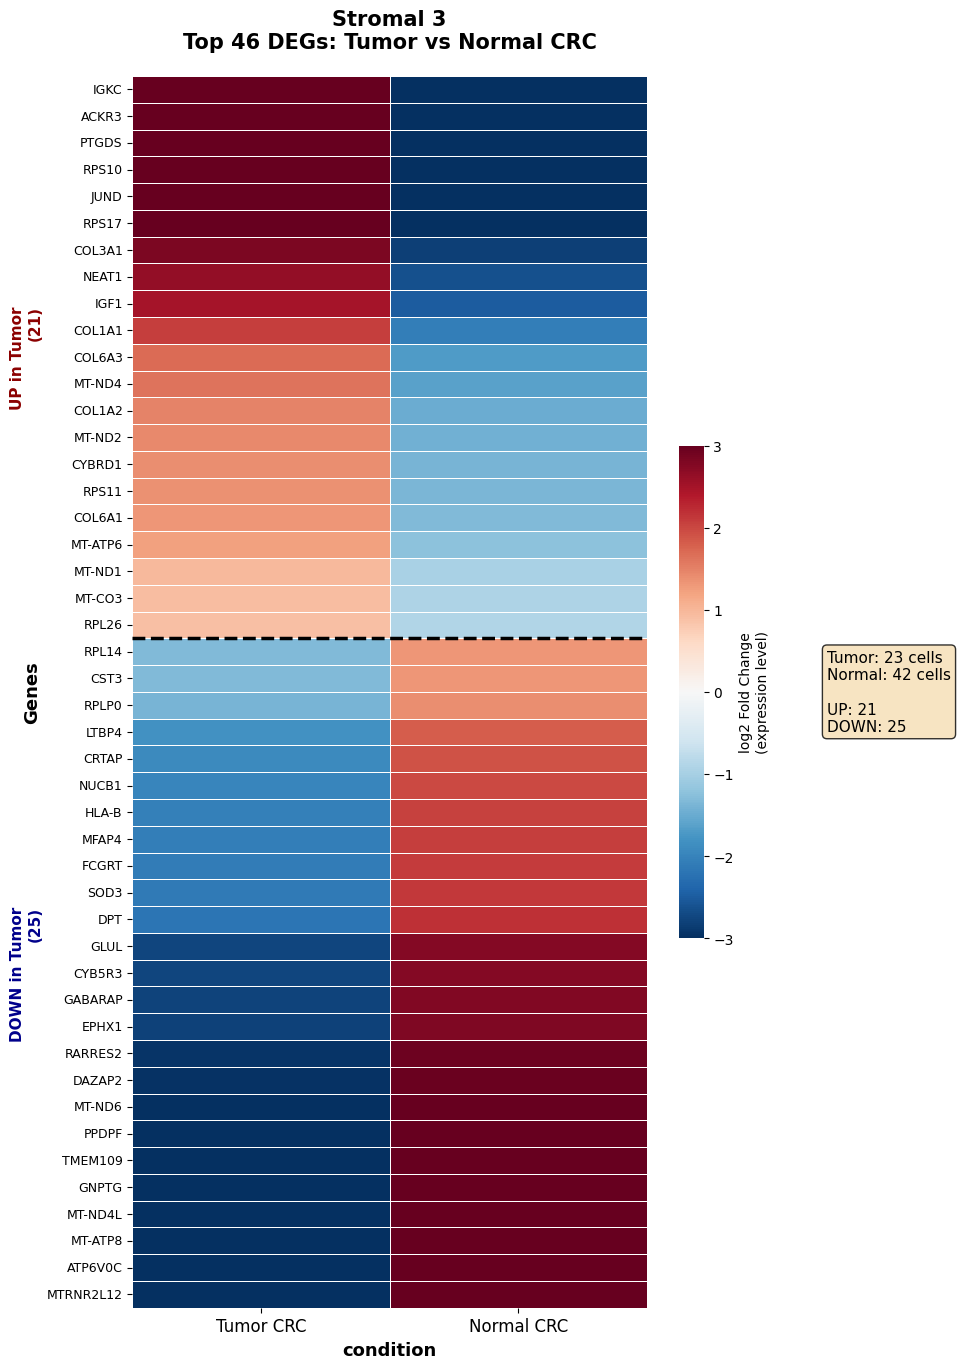

✅ Heatmap saved: heatmap_Stromal_3_log2FC.pdf
Plotted 46 genes

Processing: Follicular helper T cells
Significant DEGs found: 333
UP genes: 25, DOWN genes: 25
Total genes to plot: 50
Cells: Tumor=699, Normal=787


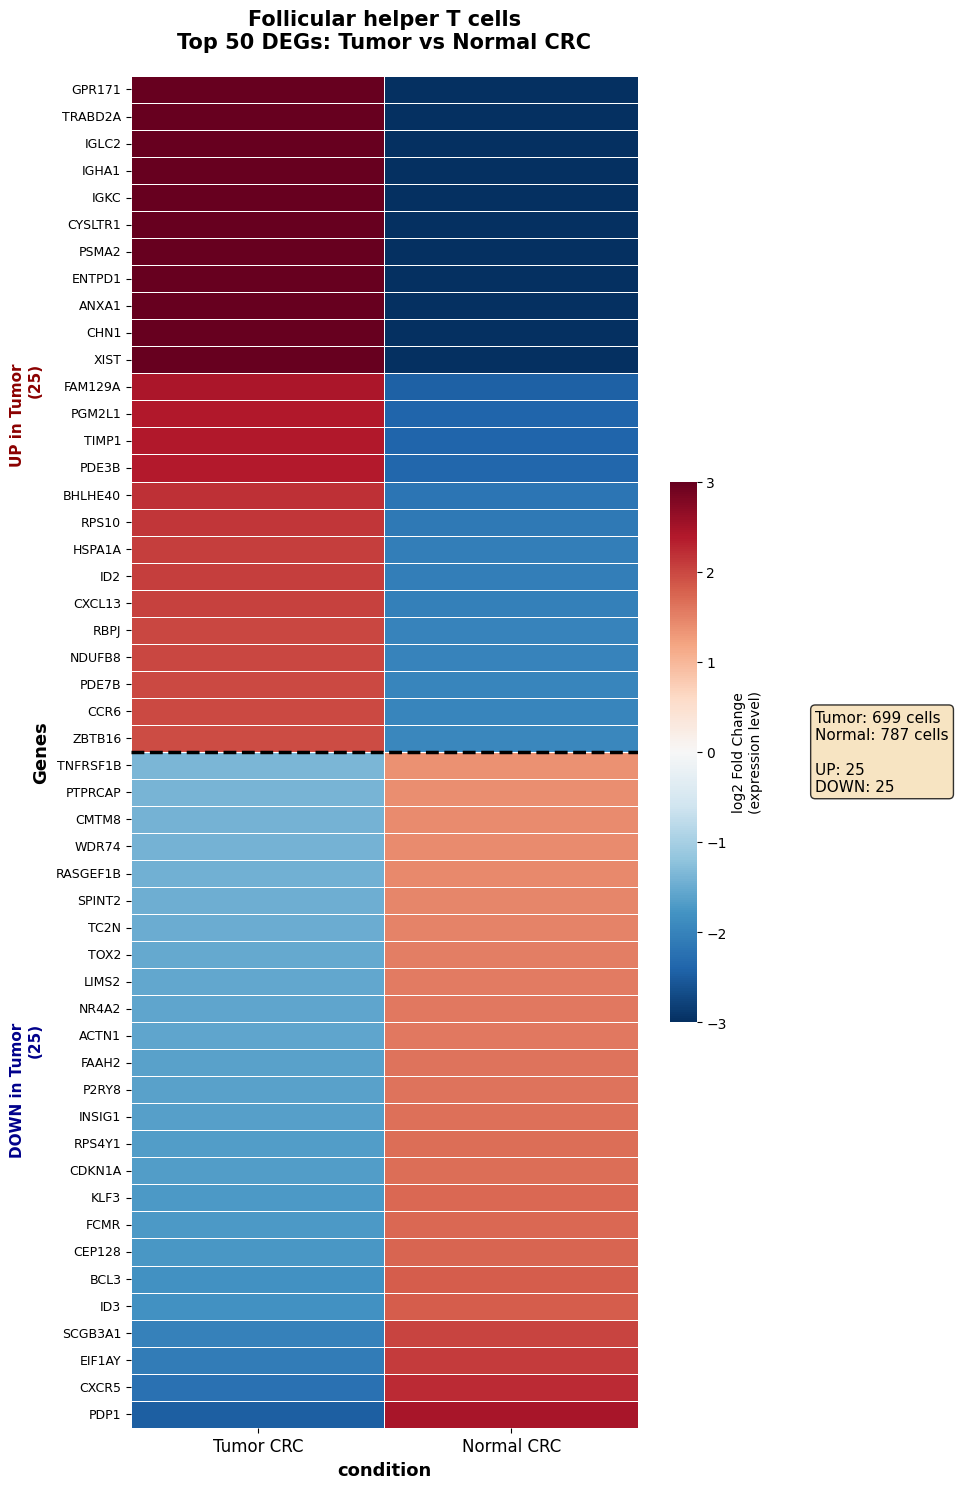

✅ Heatmap saved: heatmap_Follicular_helper_T_cells_log2FC.pdf
Plotted 50 genes

Processing: Enteric glia cells
Significant DEGs found: 9
UP genes: 3, DOWN genes: 6
Total genes to plot: 9
Cells: Tumor=20, Normal=29


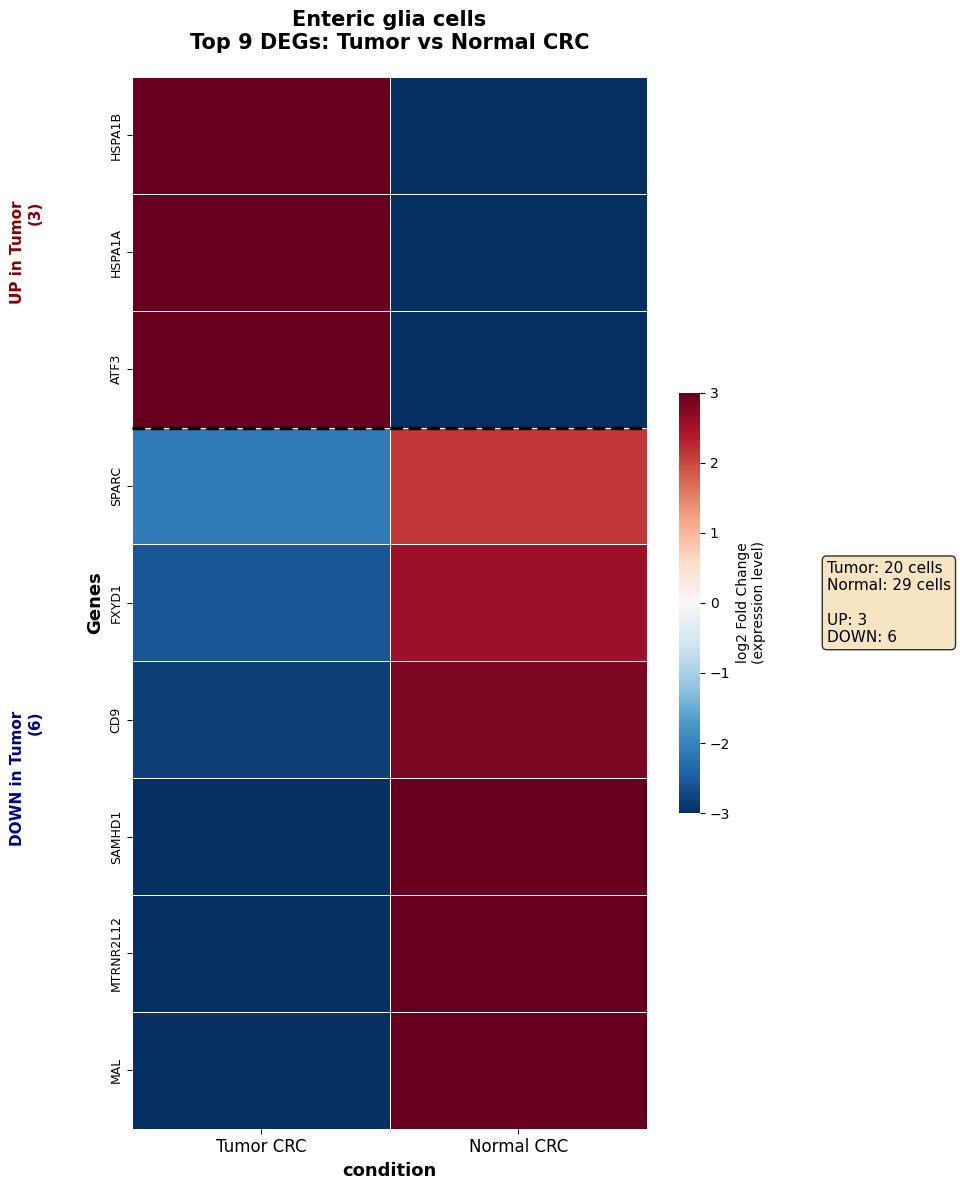

✅ Heatmap saved: heatmap_Enteric_glia_cells_log2FC.pdf
Plotted 9 genes

✅ ALL HEATMAPS COMPLETED!


In [12]:
# Get all unique cell types
cell_types = all_degs['Cell_Type'].unique()

print(f"Found {len(cell_types)} cell types")
print(f"Cell types: {list(cell_types)}\n")

# Loop through each cell type
for cell_type in cell_types:
    print(f"\n{'='*60}")
    print(f"Processing: {cell_type}")
    print(f"{'='*60}")
    
    # Get DEGs for this cell type
    ct_degs = all_degs[all_degs['Cell_Type'] == cell_type].copy()
    
    # Filter significant genes
    sig_degs = ct_degs[
        (ct_degs['pvals_adj'] < 0.05) & 
        (abs(ct_degs['logfoldchanges']) > 0.5)
    ].copy()
    
    print(f"Significant DEGs found: {len(sig_degs)}")
    
    if len(sig_degs) == 0:
        print(f"❌ No significant DEGs for {cell_type}, skipping...")
        continue
    
    # Get top 25 UP and top 25 DOWN genes
    up_genes = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(25, 'logfoldchanges')
    down_genes = sig_degs[sig_degs['logfoldchanges'] < 0].nsmallest(25, 'logfoldchanges')
    
    print(f"UP genes: {len(up_genes)}, DOWN genes: {len(down_genes)}")
    
    if len(up_genes) == 0 and len(down_genes) == 0:
        print(f"❌ No UP or DOWN genes for {cell_type}, skipping...")
        continue

    # Combine genes ordered by log2FC (high to low)
    top_genes = pd.concat([up_genes, down_genes]).sort_values('logfoldchanges', ascending=False)
    gene_list = top_genes['names'].tolist()
    
    print(f"Total genes to plot: {len(gene_list)}")
    
    # Create a dataframe with log2FC values for left and right
    heatmap_data = pd.DataFrame({
        'Tumor CRC': top_genes.set_index('names')['logfoldchanges'],
        'Normal CRC': -top_genes.set_index('names')['logfoldchanges']
    })
    
    # Reorder by original gene order
    heatmap_data = heatmap_data.loc[gene_list]
    
    # Count UP and DOWN genes
    n_up = len(up_genes)
    n_down = len(down_genes)
    
    # Get cell counts
    cell_mask = adata.obs['Cell_Type'] == cell_type
    adata_celltype = adata[cell_mask, :]
    n_tumor = (adata_celltype.obs['condition'] == 'Tumor').sum()
    n_normal = (adata_celltype.obs['condition'] == 'Normal').sum()
    
    print(f"Cells: Tumor={n_tumor}, Normal={n_normal}")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, max(12, len(gene_list) * 0.3)))

    # Plot heatmap with log2FC values
    sns.heatmap(
        heatmap_data,
        cmap='RdBu_r',
        center=0,
        vmin=-3,
        vmax=3,
        cbar_kws={'label': 'log2 Fold Change\n(expression level)', 'shrink': 0.4},
        linewidths=0.5,
        linecolor='white',
        yticklabels=True,
        xticklabels=True,
        ax=ax
    )
    
    # Formatting
    ax.set_title(f'{cell_type}\nTop {len(gene_list)} DEGs: Tumor vs Normal CRC', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('condition', fontsize=13, fontweight='bold')
    ax.set_ylabel('Genes', fontsize=13, fontweight='bold')
    
    # X-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    
    # Add dividing line between UP and DOWN genes
    if n_up > 0 and n_down > 0:
        ax.axhline(y=n_up, color='black', linewidth=2.5, linestyle='--')
        
        # Add labels for UP/DOWN sections
        ax.text(-0.35, n_up/2, f'UP in Tumor\n({n_up})', 
                rotation=90, va='center', ha='right',
                fontsize=11, fontweight='bold', color='darkred')
        ax.text(-0.35, n_up + n_down/2, 
                f'DOWN in Tumor\n({n_down})', 
                rotation=90, va='center', ha='right',
                fontsize=11, fontweight='bold', color='darkblue')

    # Add statistics box
    textstr = f'Tumor: {n_tumor} cells\nNormal: {n_normal} cells\n\nUP: {n_up}\nDOWN: {n_down}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(1.35, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    
    # Save with safe filename
    safe_filename = cell_type.replace(" ", "_").replace("+", "plus").replace("/", "_")
    plt.savefig(f'heatmap_{safe_filename}_log2FC.pdf', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Heatmap saved: heatmap_{safe_filename}_log2FC.pdf")
    print(f"Plotted {len(gene_list)} genes")

print("\n" + "="*60)
print("✅ ALL HEATMAPS COMPLETED!")
print("="*60)